In [1]:
import os
import time
import pickle
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
import torch
import torch.optim as optim

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, StratifiedKFold
from category_encoders import TargetEncoder, OneHotEncoder
from math import sqrt
from datetime import datetime

In [2]:
from src.utils import check_stationarity, get_scaler, get_sample_weight, load_word2vec_embeddings, load_fasttext_embeddings, get_torch_optimizer, dummy_lagged_df
from src.arima import grid_search_arima
from src.ml_model import grid_search_ml, get_model, one_step_prediction as one_step_ml_prediction
from src.rnn import load_data, load_data_forecast, train_rnn, eval_rnn, one_step_prediction, grid_search_rnn, TimeSeriesDataset, ForecastModel

# Forecasting FSI
Here we impute and project missing values for explanatory variable FSI using other variables
## Baseline of simple ARIMA 
Last 4 year as test

In [3]:
imputed_dir = './data/imputed/'

In [4]:
aus_df = pd.read_csv(os.path.join(imputed_dir, 'Austria.csv'))
aus_df['Date'] = pd.to_datetime(aus_df['Date'])
aus_df = aus_df.set_index('Date')
aus_df = aus_df.resample('Y').first()

In [5]:
candidates = ['GDPPerCap', 'GDP', 'Population']
target = 'FSI'

train_df = aus_df[[target] + candidates].dropna()
train_x, train_y = train_df[candidates], train_df[target]
# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-4], train_x.iloc[-4:], train_y.iloc[:-4], train_y.iloc[-4:]
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [6]:
len(test_y) / (len(train_y) + len(test_y))

0.23529411764705882

/scratch/zt00296/Projects/tourism-forecasting/src/utils.py:46: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)



The series isn't stationary


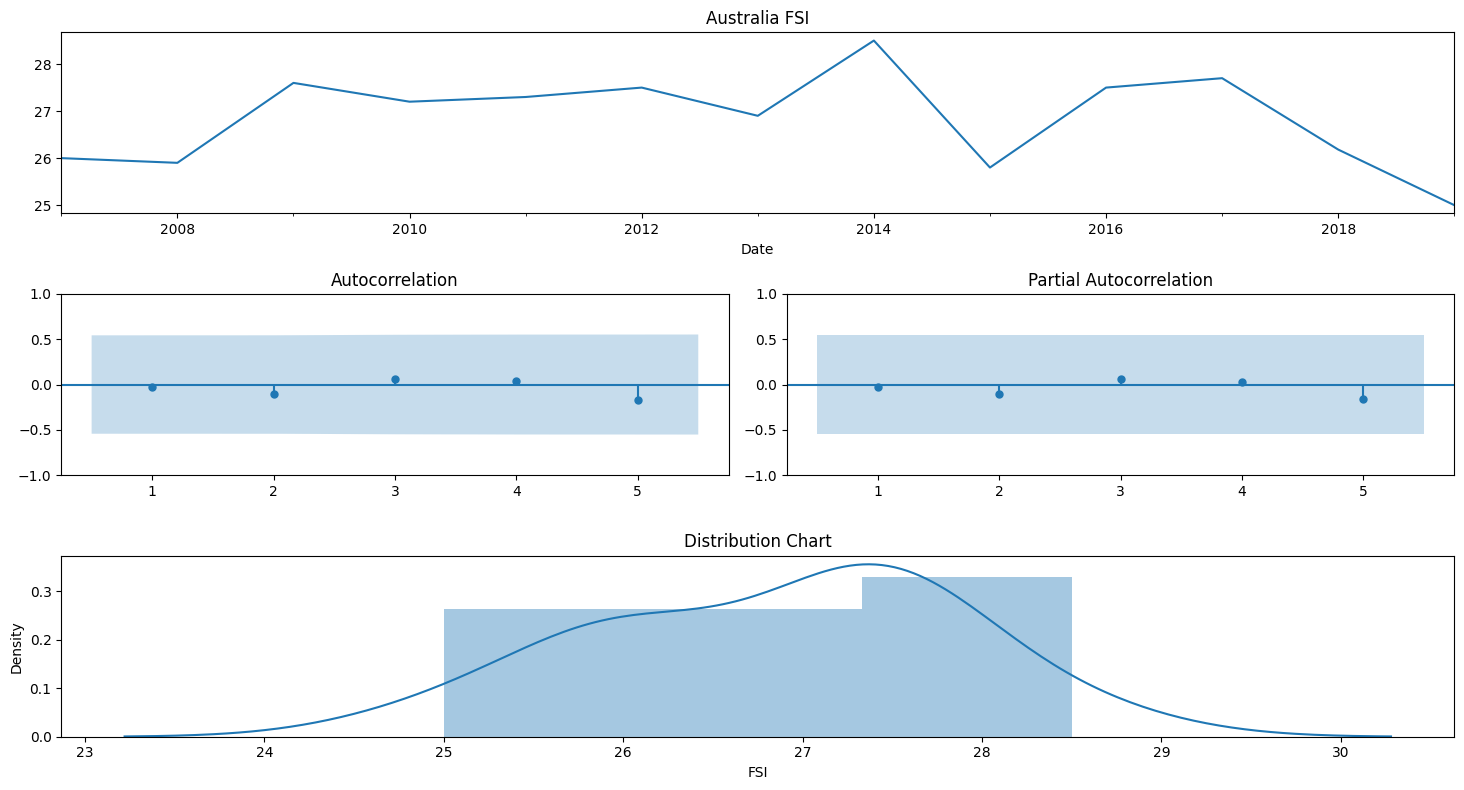

In [7]:
# find parameter analytically
check_stationarity(train_y, title='Australia FSI')

(1, 0, 1) 0.9587995722115044
RMSE: 2.3706130044614944
R2 -7.9048098167686405


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Date'>

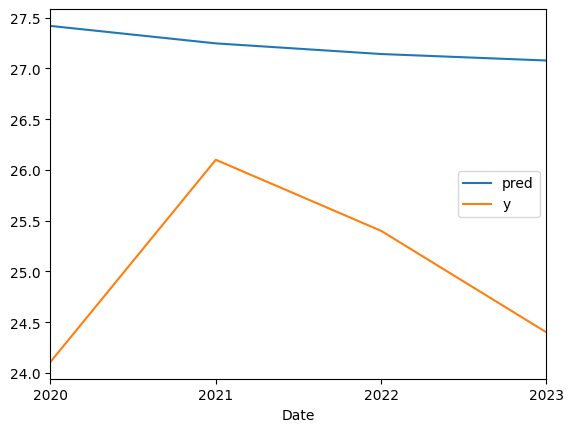

In [8]:
best_param, best_rmse = grid_search_arima(train_y)
print(best_param, best_rmse)
arima_model = sm.tsa.arima.ARIMA(train_y, order=best_param)
result = arima_model.fit()
pred = result.forecast(len(test_y))
print('RMSE:', sqrt(mean_squared_error(test_y, pred)))
print('R2', r2_score(test_y, pred))
pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [9]:
# repeat for all countries
arima_pred, all_y = [], []
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        df = pd.read_csv(os.path.join(imputed_dir, f))
        df['Date'] = pd.to_datetime(df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        df = df.set_index('Date')
        df = df.resample('Y').first()
        train_y = df[target].dropna()
        train_y, test_y = train_y.iloc[:-4], train_y.iloc[-4:]
        best_param, best_rmse = grid_search_arima(train_y)
        print(best_param, best_rmse)
        arima_model = sm.tsa.arima.ARIMA(train_y, order=best_param)
        result = arima_model.fit()
        pred = result.forecast(len(test_y))
        arima_pred.append(pred)
        all_y.append(test_y)
arima_pred, all_y = pd.concat(arima_pred).values, pd.concat(all_y).values

processing Japan.csv
(0, 1, 1) 3.4181463593563772
processing Korea (ROK).csv
(0, 1, 1) 2.1008618868178175
processing Chile.csv
(0, 1, 1) 0.9542391354574415
processing Maldives.csv
(0, 1, 1) 1.277874772253565
processing Cambodia.csv
(1, 1, 2) 1.0482132010186032
processing Singapore.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2) 1.8438528210037433
processing USA.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(1, 0, 1) 1.543266769587979
processing Chinese Taipei.csv
(1, 1, 3) 2.972269829612392
processing Thailand.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 0, 3) 1.6263616407057306
processing Indonesia.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2) 1.178613022593426
processing Turkey.csv
(1, 0, 1) 2.2507339638219057
processing Macao, China.csv
(1, 1, 3) 2.972269829612392
processing Australia.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 3) 1.599703439004182
processing New Zealand.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 3) 1.5029822530155288
processing Czech.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 0, 3) 1.9243678247497789
processing Hawaii.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 1) 1.543266769587979
processing Mexico.csv
(1, 0, 1) 2.0528631063821754
processing Hong Kong SAR.csv
(1, 1, 3) 2.972269829612392
processing Canada.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 3) 1.67698227227171
processing Austria.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 1) 0.9587995722115044


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


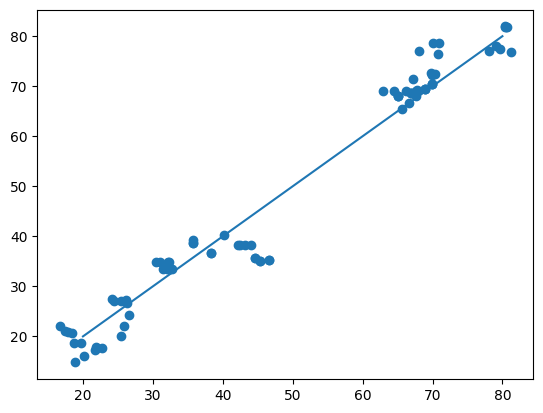

In [10]:
plt.scatter(all_y, arima_pred)
plt.plot((20, 80), (20, 80))

In [11]:
baseline_rmse = sqrt(mean_squared_error(all_y, arima_pred))
baseline_r2 = r2_score(all_y, arima_pred)
print(f'Baseline ARIMA RMSE: {baseline_rmse:.5f}\nBaseline ARIMA R2: {baseline_r2:.5f}')

Baseline ARIMA RMSE: 4.29693
Baseline ARIMA R2: 0.95883


# ARIMAX

In [12]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'CovidCases', 'CovidDeaths']
target = 'FSI'
train_df = aus_df[[target] + candidates].dropna()
train_x, train_y = train_df[candidates], train_df[target]
# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-4], train_x.iloc[-4:], train_y.iloc[:-4], train_y.iloc[-4:]
# scaler = StandardScaler()
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.transform(test_x)

(0, 0, 1)
RMSE: 3.1431442647148287
R2 -14.654238751129022


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Date'>

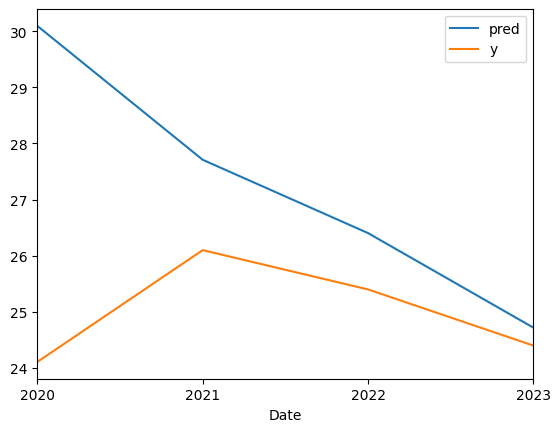

In [13]:
best_param, best_rmse = grid_search_arima(train_y, train_x)
print(best_param)
arimax_model = sm.tsa.arima.ARIMA(train_y, train_x, order=best_param)
result = arimax_model.fit()
pred = result.forecast(len(test_y), exog=test_x)
print('RMSE:', sqrt(mean_squared_error(test_y, pred)))
print('R2', r2_score(test_y, pred))
pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [14]:
# repeat for all countries
arimax_pred, all_y = [], []
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        df = pd.read_csv(os.path.join(imputed_dir, f))
        df['Date'] = pd.to_datetime(df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        df = df.set_index('Date')
        df = df.resample('Y').first()
        train_df = df[[target] + candidates].dropna()
        train_x, train_y = train_df[candidates], train_df[target]
        train_x, test_x, train_y, test_y = train_x.iloc[:-4], train_x.iloc[-4:], train_y.iloc[:-4], train_y.iloc[-4:]
        best_param, best_rmse = grid_search_arima(train_y, train_x)
        print(best_param, best_rmse)
        arimax_model = sm.tsa.arima.ARIMA(train_y, train_x, order=best_param)
        result = arimax_model.fit()
        pred = result.forecast(len(test_y), exog=test_x)
        arimax_pred.append(pred)
        all_y.append(test_y)
arimax_pred, all_y = pd.concat(arimax_pred).values, pd.concat(all_y).values

processing Japan.csv
(0, 0, 2) 9.847893546633673
processing Korea (ROK).csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 0, 3) 2.680451540263868
processing Chile.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1) 1.163324539878789
processing Maldives.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2) 2.7637964523380782
processing Cambodia.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 3) 1.570477097862679
processing Singapore.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 2) 1.6181586986903451
processing USA.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 0, 1) 1.5622489206058514
processing Chinese Taipei.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1) 1.5275336971409903
processing Thailand.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 0, 3) 1.6617809899850593
processing Indonesia.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 1) 2.2404593086805358
processing Turkey.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 2) 3.0497898158369536
processing Macao, China.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 2) 3.7779495977844504
processing Australia.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 3) 1.1741255038700658
processing New Zealand.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 0, 2) 2.5987597350656024
processing Czech.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 3) 2.3291554853707277
processing Hawaii.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2) 2.306148573043155
processing Mexico.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 3) 1.9062622577569432
processing Hong Kong SAR.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 0, 2) 1.978129859495771
processing Canada.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 3) 2.0694504655778365
processing Austria.csv


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 0, 1) 1.2707677057400344


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


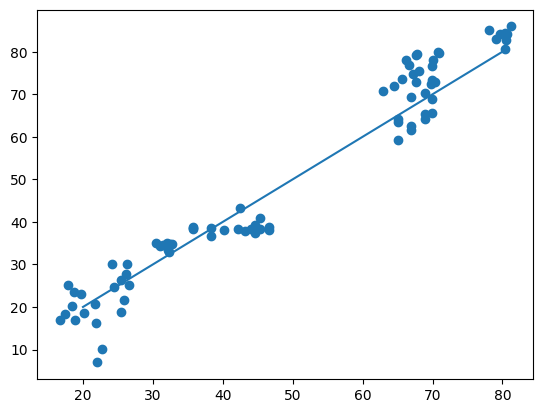

In [15]:
plt.scatter(all_y, arimax_pred)
plt.plot((20, 80), (20, 80))

In [16]:
arimax_rmse = sqrt(mean_squared_error(all_y, arimax_pred))
arimax_r2 = r2_score(all_y, arimax_pred)
print(f'Baseline ARIMAX RMSE: {arimax_rmse:.5f}\nBaseline ARIMAX R2: {arimax_r2:.5f}')

Baseline ARIMAX RMSE: 5.60279
Baseline ARIMAX R2: 0.93001


## Regression

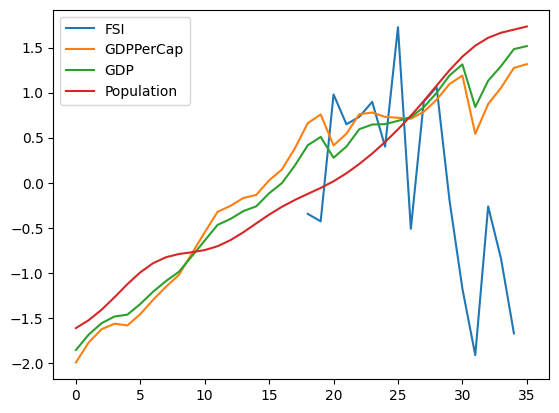

Pearson: -0.4098812325224807
Kendall: -0.15498260496951669
Spearman: -0.20968734781228798


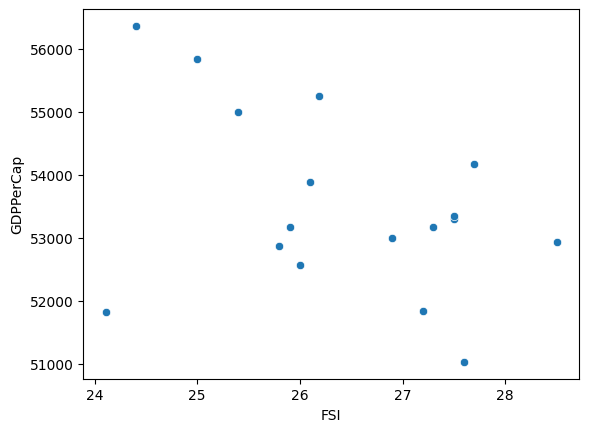

Pearson: -0.5391867332782553
Kendall: -0.3468658301698706
Spearman: -0.4733293348277378


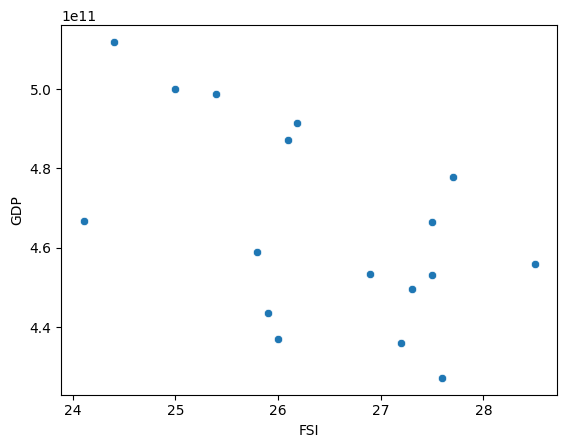

Pearson: -0.5655045499766447
Kendall: -0.3173453339852008
Spearman: -0.45861443322687545


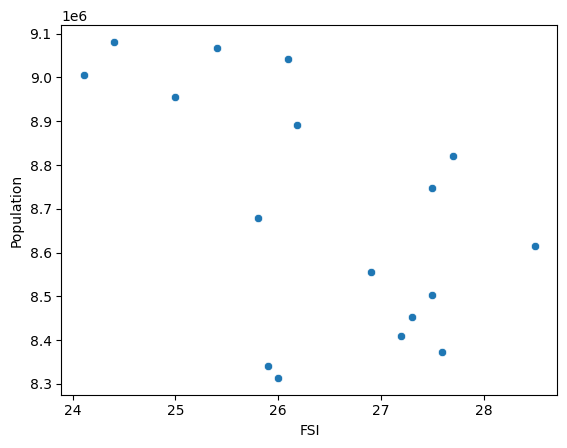

In [19]:
candidates = ['GDPPerCap', 'GDP', 'Population']
target = 'FSI'
aus_df['Year'] = aus_df.index.year
pd.DataFrame(StandardScaler().fit_transform(aus_df[[target] + candidates]), columns=[target] + candidates).plot()
plt.show()
for candidate in candidates:
    print('Pearson:', aus_df[target].corr(aus_df[candidate]))
    print('Kendall:', aus_df[target].corr(aus_df[candidate], method='kendall'))
    print('Spearman:', aus_df[target].corr(aus_df[candidate], method='spearman'))
    sns.scatterplot(aus_df, x=target, y=candidate)
    plt.show()

In [20]:
train_df = aus_df[[target] + candidates].dropna()
train_x, train_y = train_df[candidates], train_df[target]

train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=3)

# train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
train_x, test_x, train_y, test_y = train_x.iloc[:-4], train_x.iloc[-4:], train_y.iloc[:-4], train_y.iloc[-4:]

In [21]:
# sample_weight = get_sample_weight(0.5, 1.0, len(train_x))
best_param, best_rmse = grid_search_ml(train_x, train_y, #sample_weight=sample_weight,
                                         additional_params={'rf': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)],
                                                            'mlp': [{'hidden_layer_sizes': n} for n in (1, 2, 3, 5, 10)],
                                                            'xgb': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)]})
best_param, best_rmse

(('ridge',
  'minmax',
  {'alpha_per_target': False,
   'alphas': (0.1, 0.25, 0.5, 1.0, 5.0, 10.0),
   'cv': None,
   'fit_intercept': True,
   'gcv_mode': None,
   'scoring': None,
   'store_cv_values': False}),
 0.9563933812332139)

RMSE: 1.99176
R2: -5.28607


<Axes: xlabel='Date'>

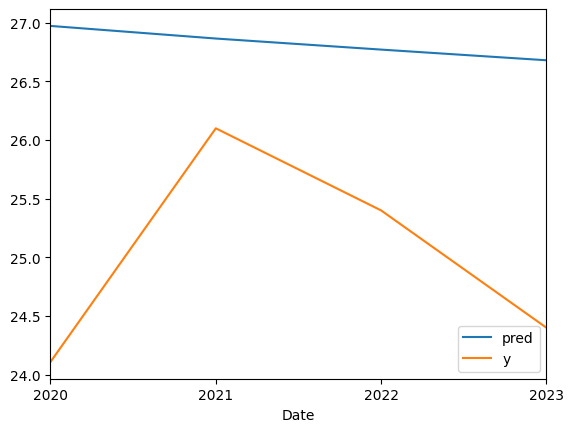

In [22]:
model = get_model(best_param[0])
model = model.set_params(**best_param[2])
scaler = get_scaler(best_param[1])
train_x_ = scaler.fit_transform(train_x)
test_x_ = scaler.transform(test_x)
model.fit(train_x_, train_y, )#sample_weight=sample_weight)
pred = model.predict(test_x_)
linear_r2 = r2_score(test_y, pred)
linear_rmse = sqrt(mean_squared_error(test_y, pred))
print(f'RMSE: {linear_rmse:.5f}\nR2: {linear_r2:.5f}')

pd.concat([pd.Series(pred, name='pred', index=test_y.index), pd.Series(test_y, name='y')], axis=1).plot()

In [23]:
# repeat for all countries
reg_pred, all_y = [], []
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        df = pd.read_csv(os.path.join(imputed_dir, f))
        df['Date'] = pd.to_datetime(df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        df = df.set_index('Date')
        df = df.resample('Y').first()

        train_df = df[[target] + candidates].dropna()
        train_x, train_y = train_df[candidates], train_df[target]
        
        train_y, train_x, _ = dummy_lagged_df(train_y, train_x, lag=3)

        train_x, test_x, train_y, test_y = train_x.iloc[:-4], train_x.iloc[-4:], train_y.iloc[:-4], train_y.iloc[-4:]
        # sample_weight = get_sample_weight(0.5, 1.0, len(train_x))

        best_param, best_rmse = grid_search_ml(train_x, train_y, #sample_weight=sample_weight,
                                                 additional_params={'rf': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)],
                                                                    'mlp': [{'hidden_layer_sizes': n} for n in (1, 2, 3, 5, 10)],
                                                                    'xgb': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)]})
        print(best_param, best_rmse)
        model = get_model(best_param[0])
        model = model.set_params(**best_param[2])
        scaler = get_scaler(best_param[1])
        train_x_ = scaler.fit_transform(train_x)
        test_x_ = scaler.transform(test_x)
        model.fit(train_x_, train_y,)# sample_weight=sample_weight)
        pred = model.predict(test_x_)
        reg_pred.append(pred)
        all_y.append(test_y)
reg_pred, all_y = np.concatenate(reg_pred), pd.concat(all_y).values

processing Japan.csv
('xgb', 'nopreprocess', {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 10, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}) 3.944887806227622
processing Korea (ROK).csv
('ridge', 'stan

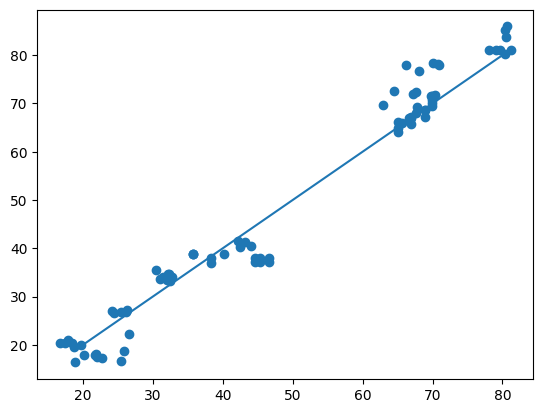

In [24]:
plt.scatter(all_y, reg_pred)
plt.plot((20, 80), (20, 80))

In [25]:
reg_rmse = sqrt(mean_squared_error(all_y, reg_pred))
reg_r2 = r2_score(all_y, reg_pred)
print(f'Baseline Model RMSE: {reg_rmse:.5f}\nBaseline Model R2: {reg_r2:.5f}')

Baseline Model RMSE: 4.21809
Baseline Model R2: 0.96033


# Combination Regression Model
combine all countries to train regression model

In [26]:
target = 'FSI'
comb_train, comb_test = [], []
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        candidates = ['GDPPerCap', 'GDP', 'Population', 'Country', 'Year']
        # print('processing', f)
        df = pd.read_csv(os.path.join(imputed_dir, f))
        df['Date'] = pd.to_datetime(df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        df = df.set_index('Date')
        df = df.resample('Y').first().reset_index(names='Date')

        df['Country'] = f.split('.')[0]
        df['Year'] = df['Date'].dt.year
        
        train_df = df[[target] + candidates].dropna()
        
        _, train_x, added_col = dummy_lagged_df(train_df[target], dropna=False, lag=1)
        train_df = pd.concat([train_df, train_x], axis=1).dropna()

        train_df, test_df = train_df.iloc[:-4], train_df.iloc[-4:]
        
        scaler = get_scaler('minmax') #scale each country stats separately
        
        temp = candidates.copy()
        temp.remove('Country')
        train_df[temp] = scaler.fit_transform(train_df[temp])
        test_df[temp] = scaler.transform(test_df[temp])
        
        comb_train.append(train_df)
        comb_test.append(test_df)
comb_train = pd.concat(comb_train, ignore_index=True)
comb_test = pd.concat(comb_test, ignore_index=True)

In [27]:
comb_train['Country'].value_counts()

Country
Turkey            13
Czech             13
Hong Kong SAR     13
Mexico            13
Hawaii            13
USA               13
Chinese Taipei    13
Thailand          13
Indonesia         13
Korea (ROK)       13
Macao, China      13
Australia         13
Canada            12
Japan             12
New Zealand       12
Singapore         12
Cambodia          12
Maldives          12
Chile             12
Austria           12
Name: count, dtype: int64

In [28]:
comb_train

,FSI,GDPPerCap,GDP,Population,Country,Year,TargetLag1
0,29.70000,0.404666,0.449504,0.990234,Japan,0.000000,28.50000
1,31.20000,0.000000,0.000000,1.000000,Japan,0.090909,29.70000
2,31.30000,0.274063,0.304316,0.992420,Japan,0.181818,31.20000
3,31.00000,0.288758,0.317971,0.966824,Japan,0.272727,31.30000
4,43.50000,0.396400,0.433152,0.922340,Japan,0.363636,31.00000
...,...,...,...,...,...,...,...
247,25.80000,0.383719,0.434630,0.549464,Austria,0.636364,28.50000
248,27.50000,0.481990,0.541279,0.661330,Austria,0.727273,25.80000
249,27.70000,0.654174,0.694840,0.779645,Austria,0.818182,27.50000
250,26.18188,0.880075,0.880766,0.896143,Austria,0.909091,27.70000


In [29]:
comb_train_x, comb_train_y = comb_train[candidates + added_col], comb_train[target]
comb_test_x, comb_test_y = comb_test[candidates + added_col], comb_test[target]

In [30]:
target_encoder = TargetEncoder(cols='Country', handle_missing='error', handle_unknown='error', min_samples_leaf=20)
comb_train_x = target_encoder.fit_transform(comb_train_x, comb_train_y)
comb_test_x = target_encoder.transform(comb_test_x)
# oh_encoder = OneHotEncoder(cols='Country', handle_missing='error', handle_unknown='error')
# comb_train_x = oh_encoder.fit_transform(comb_train_x, comb_train_y)
# comb_test_x = oh_encoder.transform(comb_test_x)


In [31]:
best_param, best_rmse = grid_search_ml(comb_train_x, comb_train_y, #sample_weight=sample_weight,
                                         additional_params={'rf': [{'n_estimators': n, 'max_depth': d, 'min_samples_leaf': 2} for n in (5, 10, 50, 100) for d in (3, 5, 7, 10)],
                                                            'mlp': [{'hidden_layer_sizes': n} for n in (1, 5, 10, 20)],
                                                            'xgb': [{'n_estimators': n, 'max_depth': d, #'subsample': 0.7, 'colsample_bytree': 0.7,
                                                                     'gamma': g, 'reg_alpha': ra} for n in (10, 50, 100, 200) for d in (3, 5, 7, 10) for g in (0., 0.01, 0.1) for ra in (0, 0.01, 0.05, 0.1)]})
print(best_param, best_rmse)
model = get_model(best_param[0])
model = model.set_params(**best_param[2])
scaler = get_scaler(best_param[1])
comb_train_x_ = scaler.fit_transform(comb_train_x)
comb_test_x_ = scaler.transform(comb_test_x)
model.fit(comb_train_x_, comb_train_y,)# sample_weight=sample_weight)
comb_pred = model.predict(comb_test_x_)

('lr', 'standard', {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}) 1.676146076746478


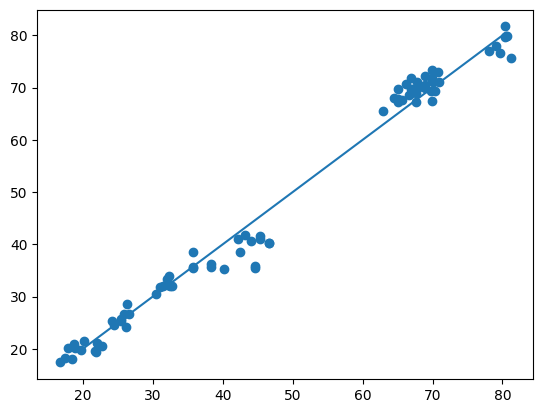

In [32]:
plt.scatter(comb_test_y, comb_pred)
plt.plot((20, 80), (20, 80))

In [33]:
reg_rmse = sqrt(mean_squared_error(comb_test_y, comb_pred))
reg_r2 = r2_score(comb_test_y, comb_pred)
print(f'Combination Model RMSE: {reg_rmse:.5f}\nCombination Model R2: {reg_r2:.5f}')

Combination Model RMSE: 2.80484
Combination Model R2: 0.98246


# RNN

In [34]:
# load pretrained embeddings
country_list = [f.split('.')[0] for f in os.listdir(imputed_dir) if f.endswith('.csv')]
emb_dict = load_fasttext_embeddings(country_list, 20)

In [35]:
candidates = ['GDPPerCap', 'GDP', 'Population', 'Country', 'ShiftedTarget'] #'CovidCases', 'CovidDeaths', 
target = 'FSI'
seq_len = 7

seq_train_x, seq_train_y, seq_test_x, seq_test_y, x_scaler, y_scaler, train_country = load_data(imputed_dir, candidates, target, seq_len, reverse=False, preprocess='nopreprocess', single_x_scaler=False, single_y_scaler=True)
# seq_test_x = pd.concat(seq_test_x, ignore_index=True)

In [36]:
seq_train_x[0]

,GDPPerCap,GDP,Population,Country,ShiftedTarget
0,39281.0,5.047361e+12,128494050.0,Japan,28.5
1,38781.0,4.984883e+12,128538644.0,Japan,29.7
2,36578.0,4.702274e+12,128555196.0,Japan,31.2
3,38070.0,4.893602e+12,128542349.0,Japan,31.3
4,38150.0,4.902186e+12,128498966.0,Japan,31.0
5,38736.0,4.974602e+12,128423571.0,Japan,43.5
6,39570.0,5.077346e+12,128314189.0,Japan,36.1


In [37]:
seq_train_y[0]

36.3

In [38]:
seq_train_x, seq_val_x, seq_train_y, seq_val_y = train_test_split(seq_train_x, seq_train_y, test_size=0.2, stratify=train_country)
train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
# train_dataset.initialize_states()
val_dataset = TimeSeriesDataset(seq_val_x, seq_val_y,)# (model.num_layers, model.hidden_size))
# val_dataset.set_initial_states(train_dataset.get_initial_states())
test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))
# test_dataset.set_initial_states(train_dataset.get_initial_states())

In [39]:
model = ForecastModel('gru', num_layers=2, conditional_labels=np.unique(train_country).tolist())
optimizer = get_torch_optimizer('sgd', model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [40]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1, pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

Epoch 0: train loss 2212.2712, val loss 689.2619, time 0.3240
Epoch 1: train loss 768.1587, val loss 515.8746, time 0.0934
Epoch 2: train loss 661.3353, val loss 572.6627, time 0.0936
Epoch 3: train loss 688.3736, val loss 482.2003, time 0.0943
Epoch 4: train loss 526.1537, val loss 480.1141, time 0.0933
Epoch 5: train loss 645.8211, val loss 476.6760, time 0.0940
Epoch 6: train loss 598.3802, val loss 477.9667, time 0.0938
Epoch 7: train loss 624.0225, val loss 517.7368, time 0.0941
Epoch 8: train loss 550.3063, val loss 480.0720, time 0.0935
Epoch 9: train loss 711.8270, val loss 493.1920, time 0.0940
Epoch 10: train loss 645.9051, val loss 496.6924, time 0.0935
Epoch 11: train loss 749.9280, val loss 480.2555, time 0.0946
Epoch 12: train loss 618.6917, val loss 512.0194, time 0.0967
Epoch 13: train loss 608.2199, val loss 476.6560, time 0.0971
Epoch 14: train loss 629.6496, val loss 478.6301, time 0.0959
Epoch 15: train loss 522.2481, val loss 497.9095, time 0.0967
Epoch 16: train l

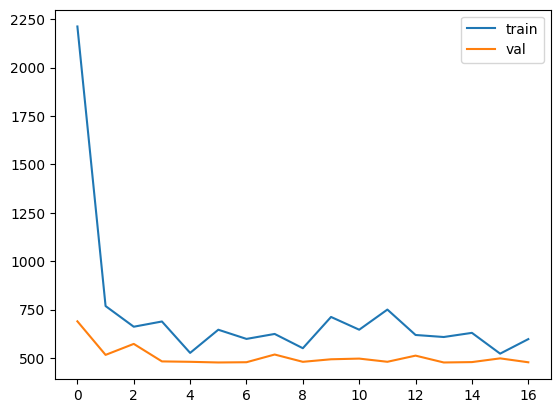

In [41]:
model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, val_dataloader, cuda=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [42]:
len(train_dataset) + len(val_dataset)

132

In [43]:
# best_param, best_rmse = grid_search_rnn(imputed_dir, candidates, target)
best_param, best_rmse = (({'preprocess': 'standard', 'seq_len': 7, 'batch_size': 16},
                          {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 20},
                          {'optim_type': 'rmsprop', 'lr': 0.001}),
                         0.07798367056850894)
best_param, best_rmse

(({'preprocess': 'standard', 'seq_len': 7, 'batch_size': 16},
  {'model_type': 'lstm', 'num_layers': 1, 'hidden_size': 20},
  {'optim_type': 'rmsprop', 'lr': 0.001}),
 0.07798367056850894)

Epoch 0: train loss 0.6181, val loss 0.2170, time 0.1710
Epoch 1: train loss 0.1880, val loss 0.1719, time 0.1618
Epoch 2: train loss 0.1068, val loss 0.1248, time 0.1619
Epoch 3: train loss 0.1163, val loss 0.0798, time 0.1621
Epoch 4: train loss 0.0944, val loss 0.0948, time 0.1611
Epoch 5: train loss 0.0869, val loss 0.0515, time 0.1622
Epoch 6: train loss 0.0636, val loss 0.0651, time 0.1616
Epoch 7: train loss 0.0696, val loss 0.0446, time 0.1614
Epoch 8: train loss 0.0632, val loss 0.0406, time 0.1621
Epoch 9: train loss 0.0619, val loss 0.0527, time 0.1607
Epoch 10: train loss 0.0507, val loss 0.0218, time 0.1606
Epoch 11: train loss 0.0416, val loss 0.0344, time 0.1607
Epoch 12: train loss 0.0463, val loss 0.0584, time 0.1627
Epoch 13: train loss 0.0515, val loss 0.0334, time 0.1617
Early stopping as no improvement in val loss


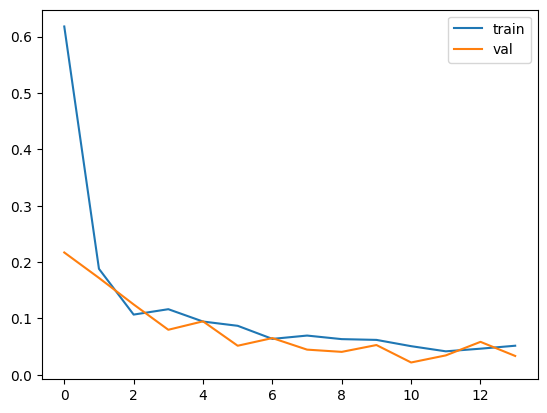

In [44]:
seq_train_x, seq_train_y, seq_test_x, seq_test_y, x_scaler, y_scaler, train_country = load_data(imputed_dir, candidates, target, best_param[0]['seq_len'], reverse=False, preprocess=best_param[0]['preprocess'], single_y_scaler=True)
model = ForecastModel(**best_param[1], conditional_labels=np.unique(train_country).tolist())
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = nn.MSELoss()

train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
# train_dataset.initialize_states()
test_dataset = TimeSeriesDataset(seq_test_x, seq_test_y,)# (model.num_layers, model.hidden_size))
# test_dataset.set_initial_states(train_dataset.get_initial_states())
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, pin_memory=True)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, test_dataloader, cuda=True)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend();

In [45]:
rnn_preds, _ = eval_rnn(model, criterion, test_dataloader)
rnn_preds = y_scaler.inverse_transform(np.expand_dims(rnn_preds, -1)).flatten()

In [46]:
dataloader_gt = []
for _, _, y_batch in test_dataloader:
    dataloader_gt.append(y_batch.item())
dataloader_gt = y_scaler.inverse_transform(np.expand_dims(np.asarray(dataloader_gt), -1)).flatten()

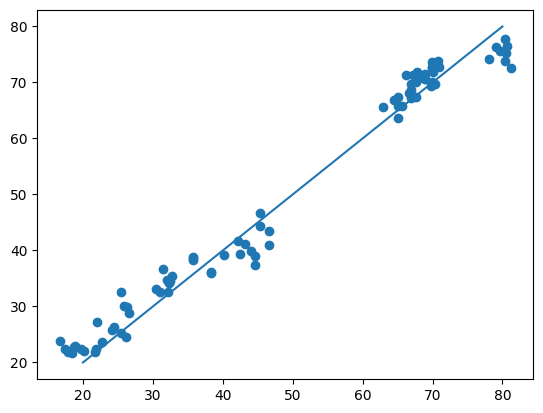

In [47]:
plt.scatter(all_y, rnn_preds)
plt.plot((20, 80), (20, 80))

In [48]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_preds))
rnn_r2 = r2_score(all_y, rnn_preds)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}')

RNN RMSE: 3.35898
RNN R2: 0.97484


# Analyze Fasttext Embeddings

In [29]:
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
print(model.conditional_labels)

['Australia', 'Austria', 'Cambodia', 'Canada', 'Chile', 'Chinese Taipei', 'Czech', 'Hawaii', 'Hong Kong SAR', 'Indonesia', 'Japan', 'Korea (ROK)', 'Macao, China', 'Maldives', 'Mexico', 'New Zealand', 'Singapore', 'Thailand', 'Turkey', 'USA']


In [30]:
country_a = 'Japan'
country_b = 'Korea (ROK)'
F.cosine_similarity(model.get_embeddings([country_a]).squeeze(), model.get_embeddings([country_b]).squeeze(), dim=0).item()

-0.2435385286808014

In [31]:
country_a = 'Japan'
country_b = 'Chinese Taipei'
F.cosine_similarity(model.get_embeddings([country_a]).squeeze(), model.get_embeddings([country_b]).squeeze(), dim=0).item()

0.9348413944244385

In [32]:
country_a = 'Japan'
country_b = 'Australia'
F.cosine_similarity(model.get_embeddings([country_a]).squeeze(), model.get_embeddings([country_b]).squeeze(), dim=0).item()

0.8689456582069397

In [34]:
all_embeddings = model.get_embeddings(model.conditional_labels).squeeze().cpu().detach().numpy()

In [27]:
tsne = TSNE(n_components=2, perplexity=5)
reduced_embeddings = tsne.fit_transform(all_embeddings)
# print(pca.explained_variance_ratio_)

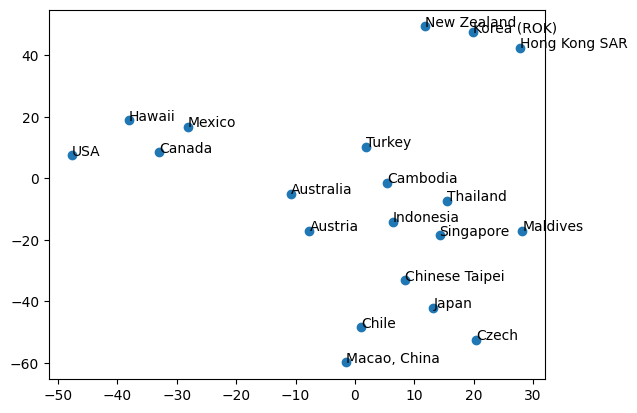

In [36]:
fig, ax = plt.subplots()
z, y = reduced_embeddings[:,0], reduced_embeddings[:,1]
ax.scatter(z, y)

for i, txt in enumerate(model.conditional_labels):
    ax.annotate(txt, (z[i], y[i]))


# Ensembling Best Models

In [49]:
rnn_rmse = sqrt(mean_squared_error(all_y, rnn_preds))
rnn_r2 = r2_score(all_y, rnn_preds)
print(f'RNN RMSE: {rnn_rmse:.5f}\nRNN R2: {rnn_r2:.5f}')

RNN RMSE: 3.35898
RNN R2: 0.97484


In [50]:
reg_rmse = sqrt(mean_squared_error(comb_test_y, comb_pred))
reg_r2 = r2_score(comb_test_y, comb_pred)
print(f'Combination Model RMSE: {reg_rmse:.5f}\nCombination Model R2: {reg_r2:.5f}')

Combination Model RMSE: 2.80484
Combination Model R2: 0.98246


In [51]:
comb_w = 0.5
for i in range(0, 11):
    comb_w = i / 10
    print(comb_w)
    ensemble_pred = comb_w * comb_pred.clip(0, 120) + (1 - comb_w) * rnn_preds.clip(0, 120)

    ensemble_rmse = sqrt(mean_squared_error(all_y, ensemble_pred))
    ensemble_r2 = r2_score(all_y, ensemble_pred)
    print(f'Ensemble Model RMSE: {ensemble_rmse:.5f}\nEnsemble Model R2: {ensemble_r2:.5f}')

0.0
Ensemble Model RMSE: 3.35898
Ensemble Model R2: 0.97484
0.1
Ensemble Model RMSE: 3.21236
Ensemble Model R2: 0.97699
0.2
Ensemble Model RMSE: 3.08122
Ensemble Model R2: 0.97883
0.3
Ensemble Model RMSE: 2.96763
Ensemble Model R2: 0.98036
0.4
Ensemble Model RMSE: 2.87366
Ensemble Model R2: 0.98159
0.5
Ensemble Model RMSE: 2.80130
Ensemble Model R2: 0.98250
0.6
Ensemble Model RMSE: 2.75224
Ensemble Model R2: 0.98311
0.7
Ensemble Model RMSE: 2.72774
Ensemble Model R2: 0.98341
0.8
Ensemble Model RMSE: 2.72847
Ensemble Model R2: 0.98340
0.9
Ensemble Model RMSE: 2.75440
Ensemble Model R2: 0.98308
1.0
Ensemble Model RMSE: 2.80484
Ensemble Model R2: 0.98246


# Full Run
Best model seems to be ensembling of combination regression model and RNN model

In [52]:
# repeat for all countries for rnn model
# no need to rerun for forecast
# best_param, best_rmse = grid_search_rnn(reverse=False, verbose=False)
candidates = ['GDPPerCap', 'GDP', 'Population', 'Country', 'ShiftedTarget'] #'CovidCases', 'CovidDeaths', 
target = 'FSI'
# best_backcast_param, best_backcast_rmse = grid_search_rnn(imputed_dir, candidates, target, emb_dict, reverse=True)
best_backcast_param, best_backcast_rmse = (({'preprocess': 'standard', 'seq_len': 7, 'batch_size': 16},
                                              {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 20},
                                              {'optim_type': 'nadam', 'lr': 0.0005}),
                                             0.0838115340230033)
best_backcast_param, best_backcast_rmse

(({'preprocess': 'standard', 'seq_len': 7, 'batch_size': 16},
  {'model_type': 'gru', 'num_layers': 1, 'hidden_size': 20},
  {'optim_type': 'nadam', 'lr': 0.0005}),
 0.0838115340230033)

Epoch 0: train loss 0.6294, time 0.1169
Epoch 1: train loss 0.2324, time 0.1066
Epoch 2: train loss 0.1393, time 0.1065
Epoch 3: train loss 0.1273, time 0.1085
Epoch 4: train loss 0.1120, time 0.1080
Epoch 5: train loss 0.1023, time 0.1073
Epoch 6: train loss 0.0836, time 0.1213
Epoch 7: train loss 0.0781, time 0.1062
Epoch 8: train loss 0.0649, time 0.1071
Epoch 9: train loss 0.0766, time 0.1069
Epoch 10: train loss 0.0579, time 0.1059
Epoch 11: train loss 0.0534, time 0.1064
Epoch 12: train loss 0.0400, time 0.1072
Epoch 13: train loss 0.0511, time 0.1087
Epoch 14: train loss 0.0569, time 0.1077
Epoch 15: train loss 0.0398, time 0.1069
Epoch 16: train loss 0.0516, time 0.1068
Epoch 17: train loss 0.0566, time 0.1119
Epoch 18: train loss 0.0425, time 0.1168
Epoch 19: train loss 0.0563, time 0.1071
warning not converged


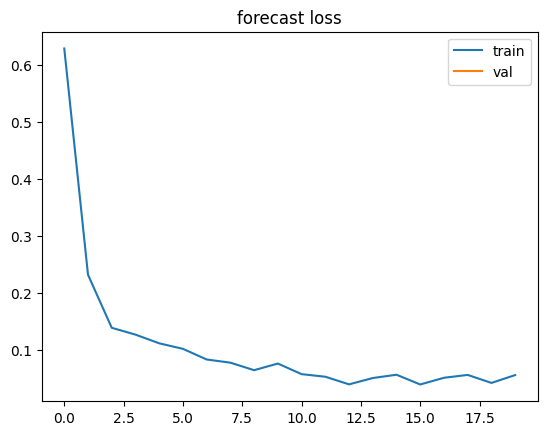

Epoch 0: train loss 1.0388, time 0.1199
Epoch 1: train loss 0.9960, time 0.1081
Epoch 2: train loss 0.9161, time 0.1090
Epoch 3: train loss 0.8443, time 0.1085
Epoch 4: train loss 0.7358, time 0.1091
Epoch 5: train loss 0.6436, time 0.1095
Epoch 6: train loss 0.5175, time 0.1199
Epoch 7: train loss 0.3593, time 0.1075
Epoch 8: train loss 0.2421, time 0.1068
Epoch 9: train loss 0.1853, time 0.1099
Epoch 10: train loss 0.1191, time 0.1094
Epoch 11: train loss 0.0678, time 0.1076
Epoch 12: train loss 0.0528, time 0.1077
Epoch 13: train loss 0.0492, time 0.1072
Epoch 14: train loss 0.0538, time 0.1099
Epoch 15: train loss 0.0534, time 0.1076
Epoch 16: train loss 0.0469, time 0.1211
Epoch 17: train loss 0.0441, time 0.1088
Epoch 18: train loss 0.0503, time 0.1098
Epoch 19: train loss 0.0448, time 0.1087
warning not converged


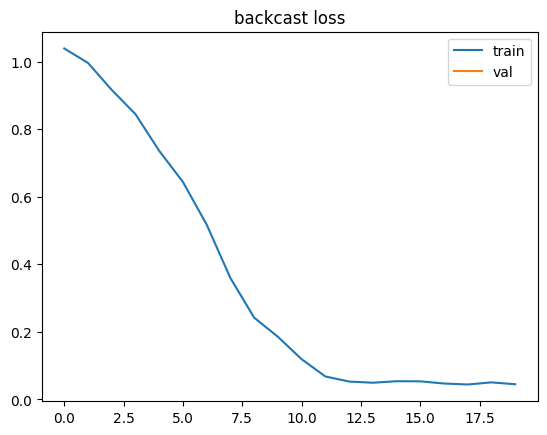

In [53]:
seq_train_x, seq_train_y, seq_test_x, seq_test_y, x_scaler, y_scaler, train_country = load_data_forecast(imputed_dir, candidates, target, best_param[0]['seq_len'], reverse=False, preprocess=best_param[0]['preprocess'])
model = ForecastModel(**best_param[1], conditional_labels=np.unique(train_country).tolist(), emb_dict=emb_dict)
optimizer = get_torch_optimizer(best_param[2]['optim_type'], model.parameters(), lr=best_param[2]['lr'])
criterion = nn.MSELoss()

# seq_train_x, seq_train_y, seq_val_x, seq_val_y = seq_train_x[:-3], seq_train_y[:-3], seq_train_x[-3:], seq_train_y[-3:]
train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_param[0]['batch_size'], pin_memory=True)

model, train_losses, val_losses = train_rnn(model, criterion, optimizer, train_dataloader, cuda=True, verbose=True, epochs=20)
forecast_predictions = one_step_prediction(model, seq_test_x, x_scaler, y_scaler)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.title('forecast loss')
plt.legend()
plt.show()

seq_train_x, seq_train_y, back_seq_test_x, back_seq_test_y, back_x_scaler, back_y_scaler, train_country = load_data_forecast(imputed_dir, candidates, target, best_backcast_param[0]['seq_len'], reverse=True, preprocess=best_backcast_param[0]['preprocess'])
back_model = ForecastModel(**best_backcast_param[1], conditional_labels=np.unique(train_country).tolist(), emb_dict=emb_dict)
optimizer = get_torch_optimizer(best_backcast_param[2]['optim_type'], back_model.parameters(), lr=best_backcast_param[2]['lr'])
criterion = nn.MSELoss()

# seq_train_x, seq_train_y, seq_val_x, seq_val_y = seq_train_x[:-3], seq_train_y[:-3], seq_train_x[-3:], seq_train_y[-3:]
train_dataset = TimeSeriesDataset(seq_train_x, seq_train_y,)# (model.num_layers, model.hidden_size))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=best_backcast_param[0]['batch_size'], pin_memory=True)

back_model, back_train_losses, back_val_losses = train_rnn(back_model, criterion, optimizer, train_dataloader, cuda=True, verbose=True, epochs=20)
backcast_predictions = one_step_prediction(back_model, back_seq_test_x, back_x_scaler, back_y_scaler)
plt.plot(back_train_losses, label='train')
plt.plot(back_val_losses, label='val')
plt.title('backcast loss')
plt.legend()
plt.show()

processing Japan.csv


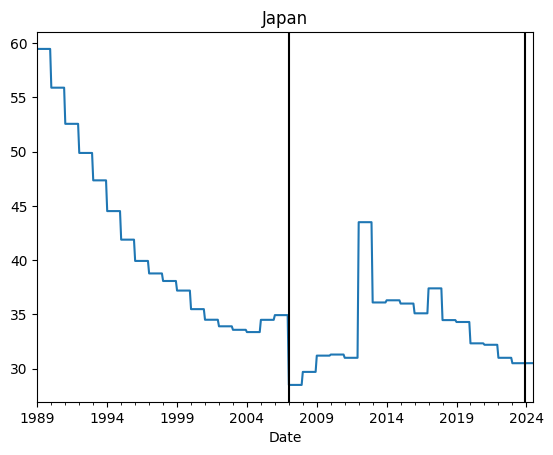

processing Korea (ROK).csv


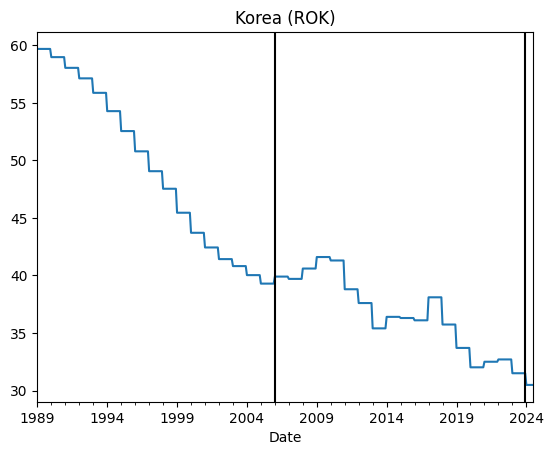

processing Chile.csv


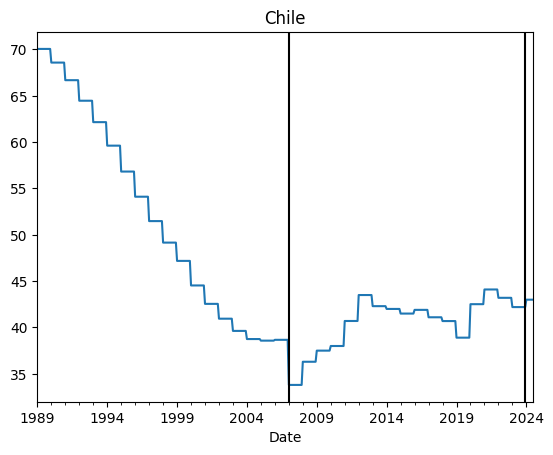

processing Maldives.csv


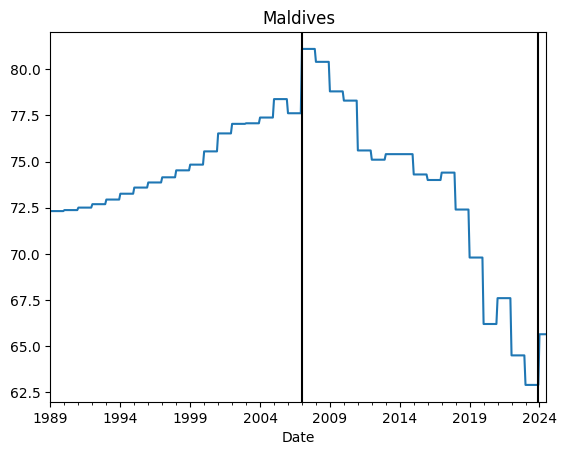

processing Cambodia.csv


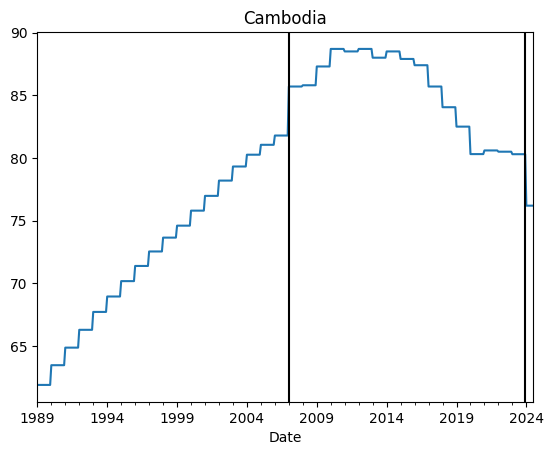

processing Singapore.csv


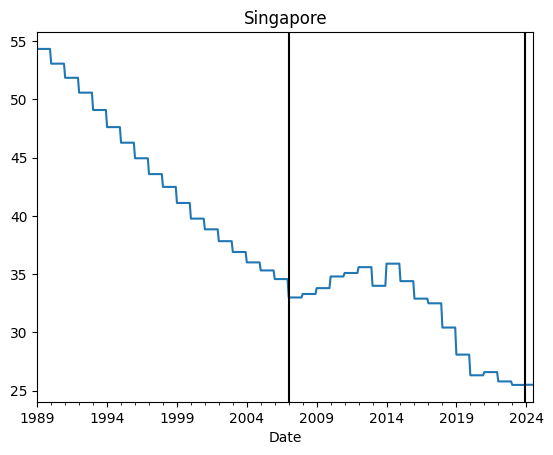

processing USA.csv


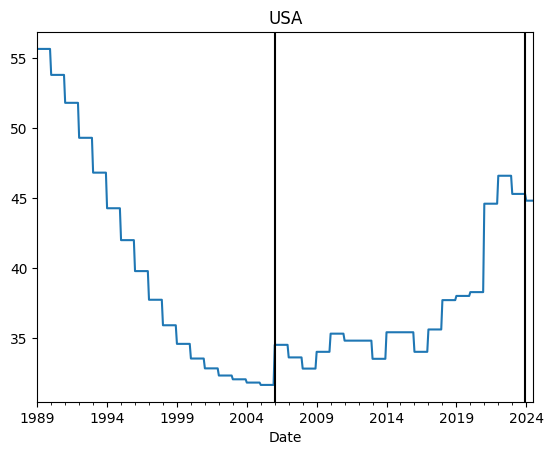

processing Chinese Taipei.csv


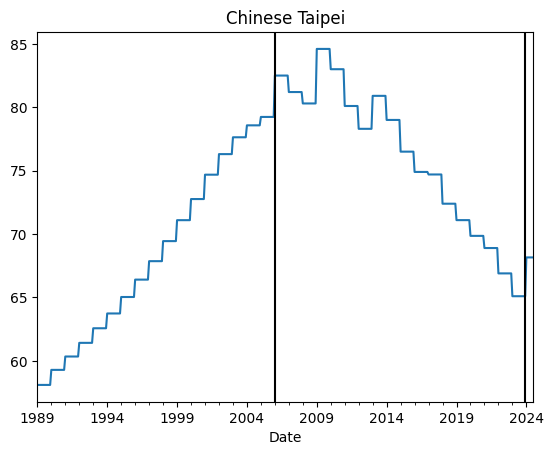

processing Thailand.csv


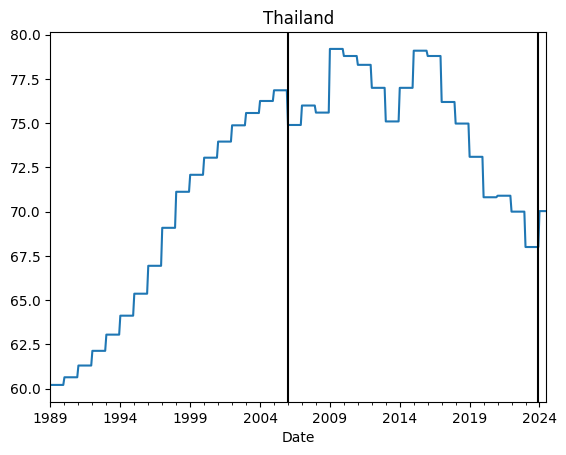

processing Indonesia.csv


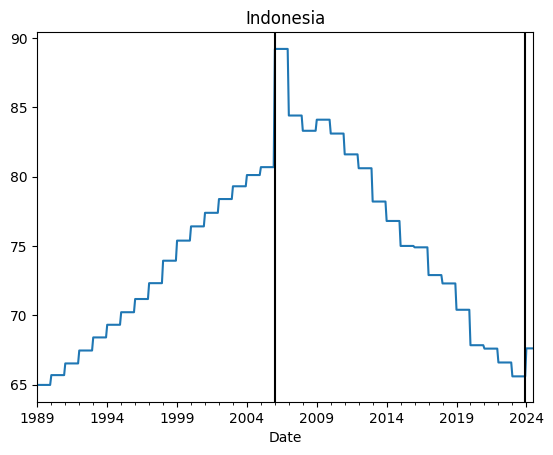

processing Turkey.csv


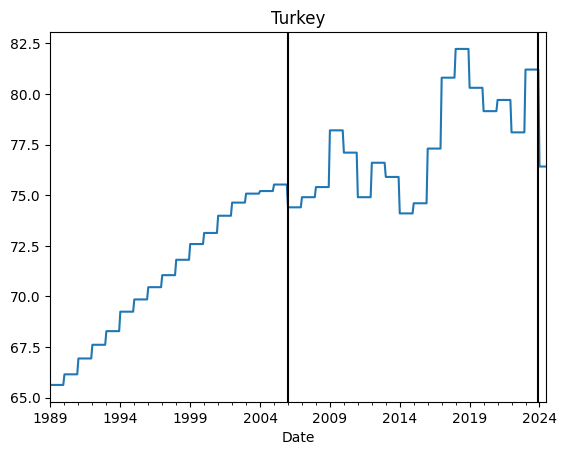

processing Macao, China.csv


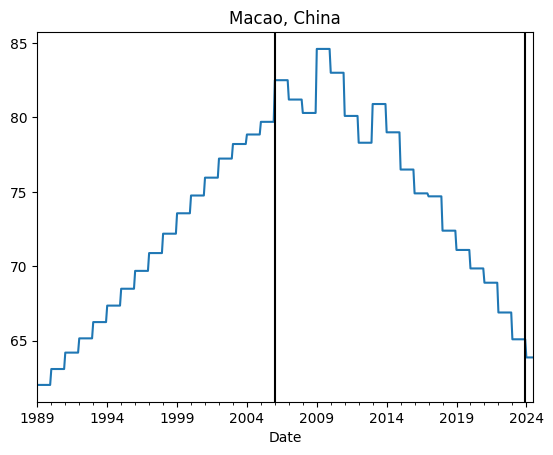

processing Australia.csv


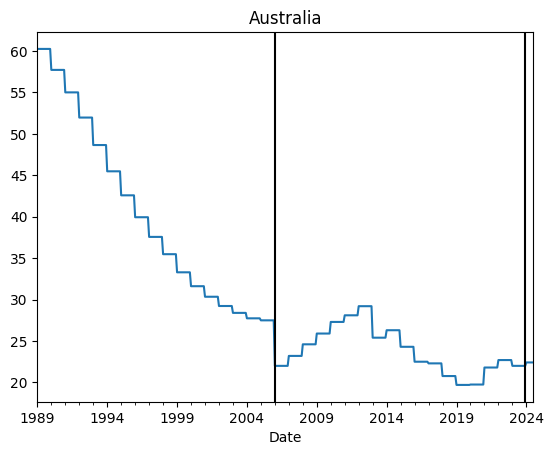

processing New Zealand.csv


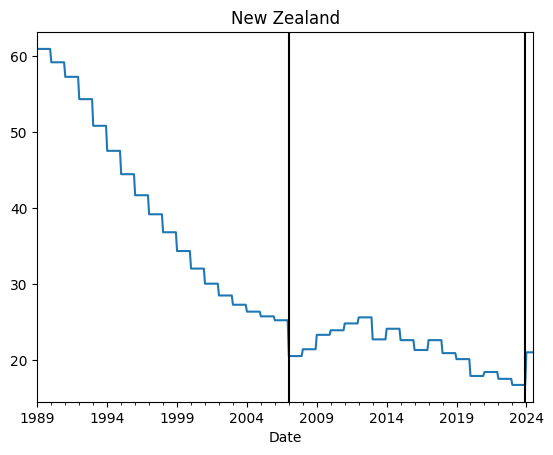

processing Czech.csv


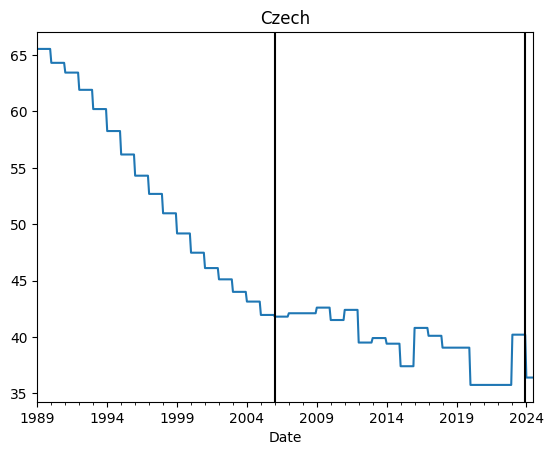

processing Hawaii.csv


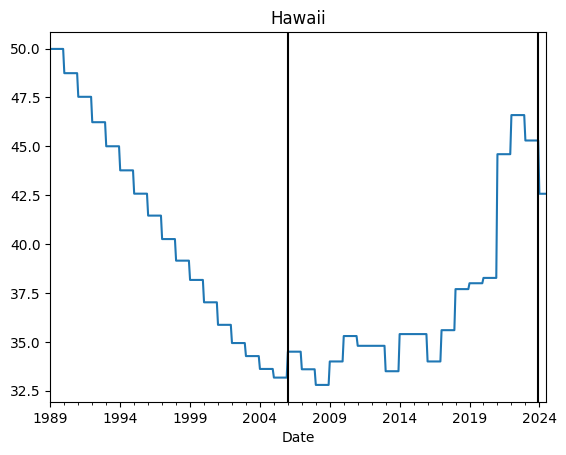

processing Mexico.csv


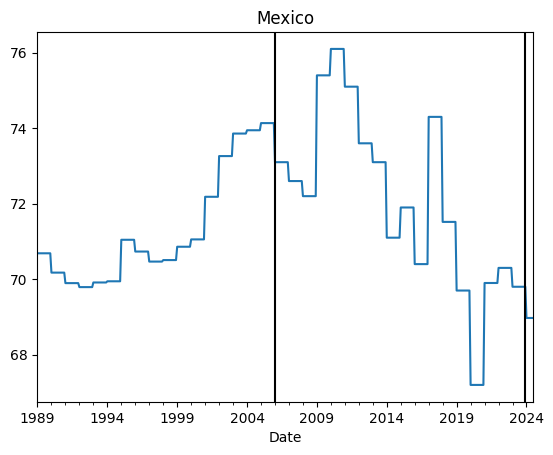

processing Hong Kong SAR.csv


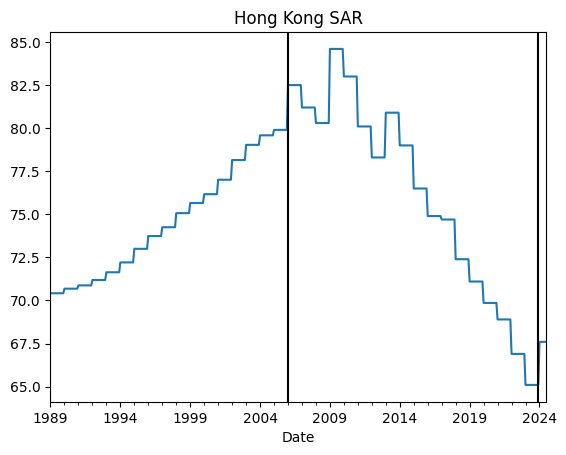

processing Canada.csv


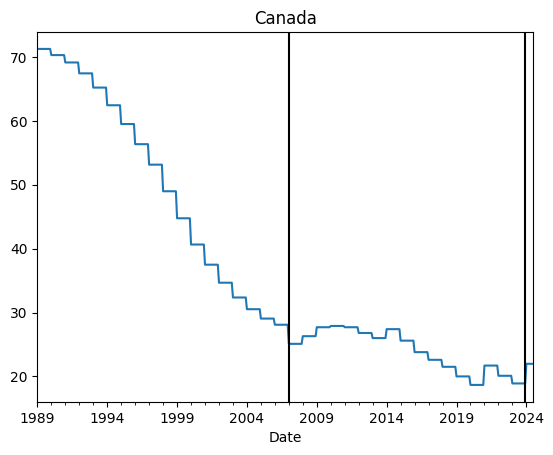

processing Austria.csv


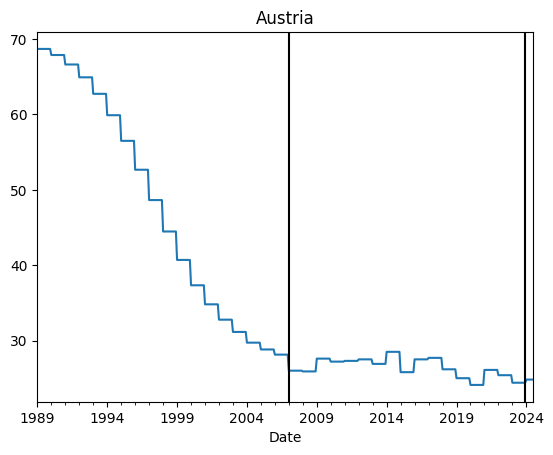

In [54]:
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        country = f.split('.')[0]
        full_df = pd.read_csv(os.path.join(imputed_dir, f))
        full_df['Date'] = pd.to_datetime(full_df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        full_df = full_df.set_index('Date')
        start_date, end_date = full_df['FSI'].first_valid_index(), full_df['FSI'].last_valid_index()
        df = full_df.copy()
        df = df.resample('YS').first().reset_index(names='Date')
        df.loc[:df['FSI'].first_valid_index() - 1, 'FSI'] = backcast_predictions[country][::-1]
        df.loc[df['FSI'].last_valid_index() + 1:, 'FSI'] = forecast_predictions[country]
        df = df.set_index('Date').resample('MS').ffill()
        
        full_df['FSI'] = full_df['FSI'].fillna(df['FSI']).ffill()
        full_df.reset_index(names='Date')
        full_df['FSI'].plot()
        plt.title(country)
        plt.axvline(start_date, color='black')
        plt.axvline(end_date, color='black')
        plt.show()
        # break
        # full_df.to_csv(os.path.join(imputed_dir, f))

In [55]:
full_df

,VisitorArrivals,FXAgainstChina,CovidCases,CovidDeaths,FSI,GDPPerCap,GDP,Population,HotelsCount,RoomsCount,...,ChinaGDPPerCap,ChinaGDP,Latitude,Longitude,DistFromChina,Country,GDPRatioChina,GDPPerCapRatioChina,GDPGrowthDiffChina,GDPPerCapGrowthDiffChina
Date,,,,,,,,,,,,,,,,,,,,,
1989-01-01,NaN,0.239173,0.0,0.0,68.695871,36109.000000,2.775505e+11,7686564.0,NaN,NaN,...,1512.000000,1.751429e+12,47.516231,14.550072,7154.855428,Austria,0.158471,23.881614,8.167625,9.509397
1989-02-01,NaN,0.241942,0.0,0.0,68.695871,36224.500000,2.785551e+11,7689680.0,NaN,NaN,...,1504.666667,1.745123e+12,47.516231,14.550072,7154.855428,Austria,0.159667,24.085709,8.208993,9.521821
1989-03-01,NaN,0.243606,0.0,0.0,68.695871,36340.000000,2.795598e+11,7692796.0,NaN,NaN,...,1497.333333,1.738818e+12,47.516231,14.550072,7154.855428,Austria,0.160863,24.289805,8.250360,9.534244
1989-04-01,NaN,0.244129,0.0,0.0,68.695871,36455.500000,2.805644e+11,7695912.0,NaN,NaN,...,1490.000000,1.732512e+12,47.516231,14.550072,7154.855428,Austria,0.162058,24.493900,8.291727,9.546668
1989-05-01,NaN,0.253504,0.0,0.0,68.695871,36571.000000,2.815691e+11,7699027.0,NaN,NaN,...,1482.666667,1.726206e+12,47.516231,14.550072,7154.855428,Austria,0.163254,24.697995,8.333094,9.559092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,NaN,NaN,NaN,NaN,24.818468,56686.733659,5.150574e+11,9098325.0,NaN,NaN,...,20553.731670,2.997738e+13,47.516231,14.550072,7154.855428,Austria,0.017188,2.758905,-5.196128,-4.859498
2024-04-01,NaN,NaN,NaN,NaN,24.818468,56718.775079,5.154755e+11,9099519.0,NaN,NaN,...,20645.508582,3.012000e+13,47.516231,14.550072,7154.855428,Austria,0.017122,2.748516,-5.155348,-4.846297
2024-05-01,NaN,NaN,NaN,NaN,24.818468,56750.816499,5.158936e+11,9100714.0,NaN,NaN,...,20737.285493,3.026262e+13,47.516231,14.550072,7154.855428,Austria,0.017057,2.738127,-5.114568,-4.833097


In [56]:
# repeat for combination regression
# forward
target = 'FSI'

all_df, comb_train, comb_test = [], [], []
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        candidates = ['GDPPerCap', 'GDP', 'Population', 'Country', 'Year']
        # print('processing', f)
        df = pd.read_csv(os.path.join(imputed_dir, f))
        df['Date'] = pd.to_datetime(df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        df = df.set_index('Date')
        df = df.resample('Y').first().reset_index(names='Date')

        df['Country'] = f.split('.')[0]
        df['Year'] = df['Date'].dt.year
        
        all_df.append(df[[target] + candidates].copy())
        
        train_df = df[[target] + candidates].dropna()
        
        _, train_x, added_col = dummy_lagged_df(train_df[target], dropna=False, lag=1)
        train_df = pd.concat([train_df, train_x], axis=1).dropna()

        train_df, test_df = train_df.iloc[:-4], train_df.iloc[-4:]
        
        scaler = get_scaler('minmax') #scale each country stats separately
        
        temp = candidates.copy()
        temp.remove('Country')
        train_df[temp] = scaler.fit_transform(train_df[temp])
        test_df[temp] = scaler.transform(test_df[temp])
        
        comb_train.append(train_df)
        comb_test.append(test_df)
comb_train = pd.concat(comb_train, ignore_index=True)
comb_test = pd.concat(comb_test, ignore_index=True)
comb_train_x, comb_train_y = comb_train[candidates + added_col], comb_train[target]
comb_test_x, comb_test_y = comb_test[candidates + added_col], comb_test[target]

target_encoder = TargetEncoder(cols='Country', handle_missing='error', handle_unknown='error', min_samples_leaf=20)
comb_train_x = target_encoder.fit_transform(comb_train_x, comb_train_y)
comb_test_x = target_encoder.transform(comb_test_x)

# best_param, best_rmse = grid_search_ml(comb_train_x, comb_train_y, #sample_weight=sample_weight,
#                                          additional_params={'rf': [{'n_estimators': n, 'max_depth': d, 'min_samples_leaf': 2} for n in (5, 10, 50, 100) for d in (3, 5, 7, 10)],
#                                                             'mlp': [{'hidden_layer_sizes': n} for n in (1, 5, 10, 20)],
#                                                             'xgb': [{'n_estimators': n, 'max_depth': d, #'subsample': 0.7, 'colsample_bytree': 0.7,
#                                                                      'gamma': g, 'reg_alpha': ra} for n in (10, 50, 100, 200) for d in (3, 5, 7, 10) for g in (0., 0.01, 0.1) for ra in (0, 0.01, 0.05, 0.1)]})
best_param, best_rmse = ('lr', 'standard', {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}), 1.676146076746478

print(best_param, best_rmse)
all_train, all_test = [], []
country_scaler = {}
for df in all_df:
    train_df = df.iloc[df[target].first_valid_index():]
    _, train_x, added_col = dummy_lagged_df(train_df[target], dropna=False, lag=1)
    train_df = pd.concat([train_df, train_x], axis=1).reset_index(drop=True)

    train_df, test_df = train_df.iloc[:train_df[target].last_valid_index()].dropna(), train_df.iloc[train_df[target].last_valid_index()+1:]

    scaler = get_scaler('minmax') #scale each country stats separately

    temp = candidates.copy()
    temp.remove('Country')
    train_df[temp] = scaler.fit_transform(train_df[temp])
    country_scaler[train_df['Country'].unique()[0]] = scaler
    all_train.append(train_df)
    all_test.append(test_df)

all_train = pd.concat(all_train)
all_test = pd.concat(all_test)
all_train_x, all_train_y = all_train[candidates + added_col], all_train[target]
target_encoder = TargetEncoder(cols='Country', handle_missing='error', handle_unknown='error', min_samples_leaf=20)
all_train_x = target_encoder.fit_transform(all_train_x, all_train_y)

model = get_model(best_param[0])
model = model.set_params(**best_param[2])
scaler = get_scaler(best_param[1])
all_train_x = scaler.fit_transform(all_train_x)
model.fit(all_train_x, all_train_y,)# sample_weight=sample_weight)
forward_comb_pred = one_step_ml_prediction(all_df, candidates, target, model, country_scaler, target_encoder, scaler, lag=1)

# backward
target = 'FSI'

all_df, comb_train, comb_test = [], [], []
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        candidates = ['GDPPerCap', 'GDP', 'Population', 'Country', 'Year']
        # print('processing', f)
        df = pd.read_csv(os.path.join(imputed_dir, f))
        df['Date'] = pd.to_datetime(df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        df = df.set_index('Date')
        df = df.resample('Y').first().reset_index(names='Date').iloc[::-1].reset_index(drop=True)

        df['Country'] = f.split('.')[0]
        df['Year'] = df['Date'].dt.year
        
        all_df.append(df[[target] + candidates].copy())
        
        train_df = df[[target] + candidates].dropna()
        
        _, train_x, added_col = dummy_lagged_df(train_df[target], dropna=False, lag=1)
        train_df = pd.concat([train_df, train_x], axis=1).dropna()

        train_df, test_df = train_df.iloc[:-4], train_df.iloc[-4:]
        
        scaler = get_scaler('minmax') #scale each country stats separately
        
        temp = candidates.copy()
        temp.remove('Country')
        train_df[temp] = scaler.fit_transform(train_df[temp])
        test_df[temp] = scaler.transform(test_df[temp])
        
        comb_train.append(train_df)
        comb_test.append(test_df)
comb_train = pd.concat(comb_train, ignore_index=True)
comb_test = pd.concat(comb_test, ignore_index=True)
comb_train_x, comb_train_y = comb_train[candidates + added_col], comb_train[target]
comb_test_x, comb_test_y = comb_test[candidates + added_col], comb_test[target]

target_encoder = TargetEncoder(cols='Country', handle_missing='error', handle_unknown='error', min_samples_leaf=20)
comb_train_x = target_encoder.fit_transform(comb_train_x, comb_train_y)
comb_test_x = target_encoder.transform(comb_test_x)

# best_param, best_rmse = grid_search_ml(comb_train_x, comb_train_y, #sample_weight=sample_weight,
#                                          additional_params={'rf': [{'n_estimators': n, 'max_depth': d, 'min_samples_leaf': 2} for n in (5, 10, 50, 100) for d in (3, 5, 7, 10)],
#                                                             'mlp': [{'hidden_layer_sizes': n} for n in (1, 5, 10, 20)],
#                                                             'xgb': [{'n_estimators': n, 'max_depth': d, #'subsample': 0.7, 'colsample_bytree': 0.7,
#                                                                      'gamma': g, 'reg_alpha': ra} for n in (10, 50, 100, 200) for d in (3, 5, 7, 10) for g in (0., 0.01, 0.1) for ra in (0, 0.01, 0.05, 0.1)]})
best_param, best_rmse = ('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}), 1.6472936691015243

print(best_param, best_rmse)
all_train, all_test = [], []
country_scaler = {}
for df in all_df:
    train_df = df.iloc[df[target].first_valid_index():]
    _, train_x, added_col = dummy_lagged_df(train_df[target], dropna=False, lag=1)
    train_df = pd.concat([train_df, train_x], axis=1).reset_index(drop=True)

    train_df, test_df = train_df.iloc[:train_df[target].last_valid_index()].dropna(), train_df.iloc[train_df[target].last_valid_index()+1:]

    scaler = get_scaler('minmax') #scale each country stats separately

    temp = candidates.copy()
    temp.remove('Country')
    train_df[temp] = scaler.fit_transform(train_df[temp])
    country_scaler[train_df['Country'].unique()[0]] = scaler
    all_train.append(train_df)
    all_test.append(test_df)

all_train = pd.concat(all_train)
all_test = pd.concat(all_test)
all_train_x, all_train_y = all_train[candidates + added_col], all_train[target]
target_encoder = TargetEncoder(cols='Country', handle_missing='error', handle_unknown='error', min_samples_leaf=20)
all_train_x = target_encoder.fit_transform(all_train_x, all_train_y)

model = get_model(best_param[0])
model = model.set_params(**best_param[2])
scaler = get_scaler(best_param[1])
all_train_x = scaler.fit_transform(all_train_x)
model.fit(all_train_x, all_train_y,)# sample_weight=sample_weight)
backward_comb_pred = one_step_ml_prediction(all_df, candidates, target, model, country_scaler, target_encoder, scaler, lag=1)

('lr', 'standard', {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}) 1.676146076746478
('elastic', 'standard', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 1.6472936691015243


processing Japan.csv


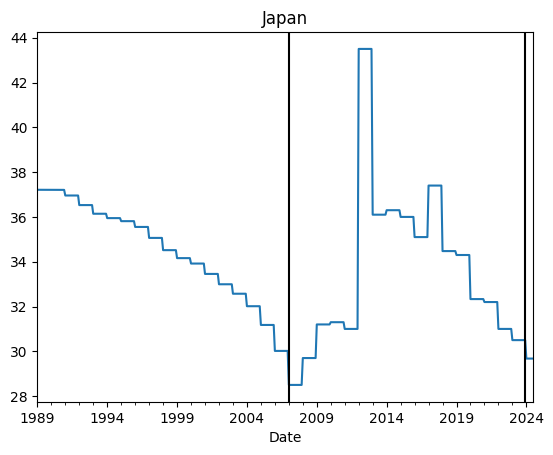

processing Korea (ROK).csv


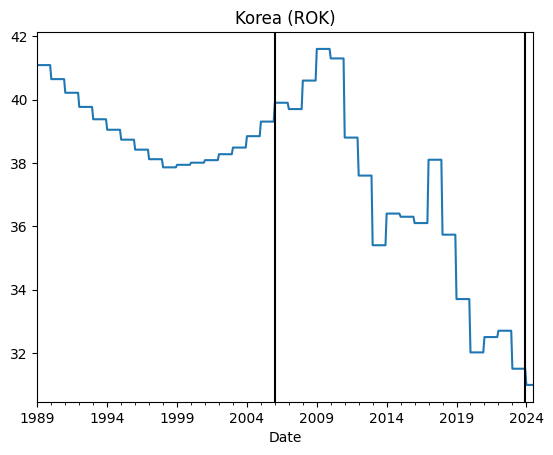

processing Chile.csv


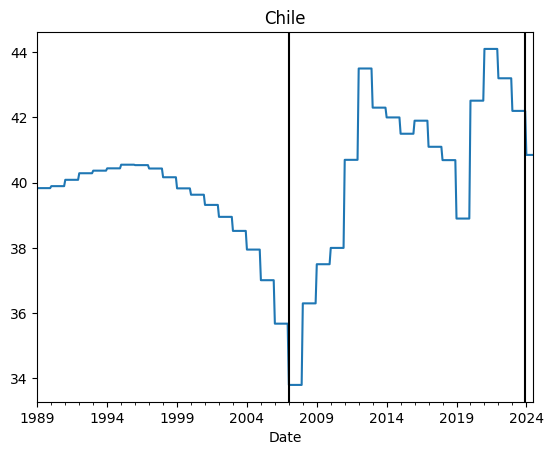

processing Maldives.csv


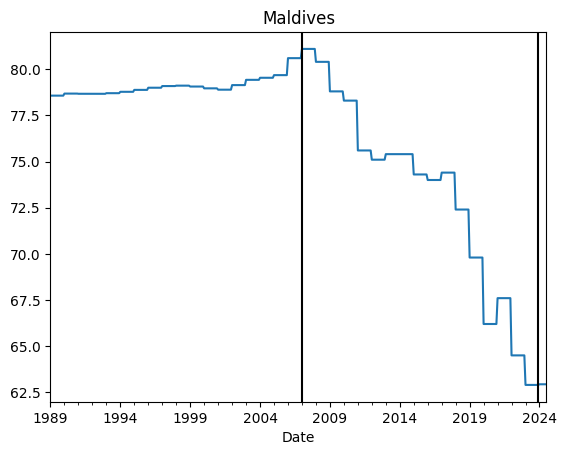

processing Cambodia.csv


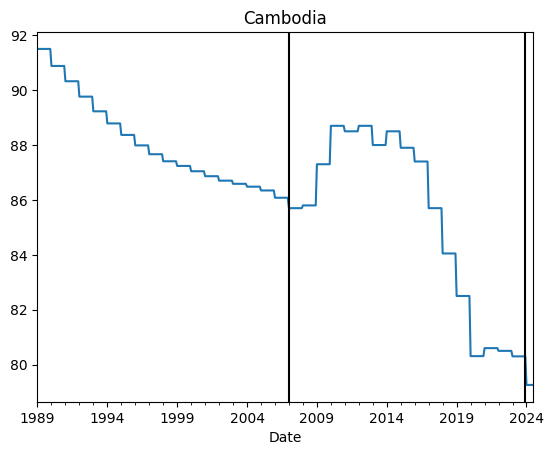

processing Singapore.csv


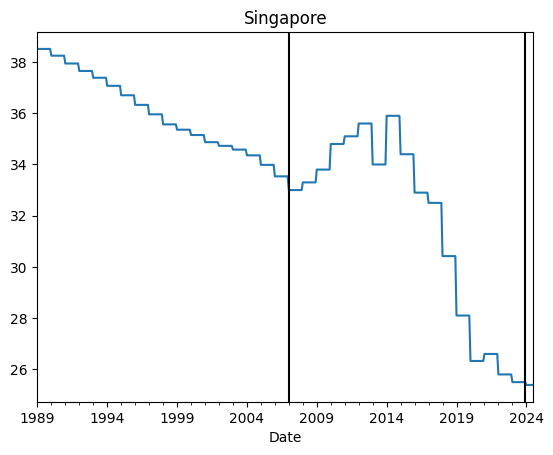

processing USA.csv


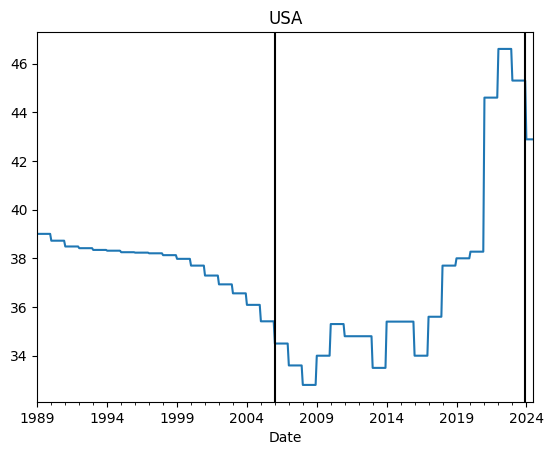

processing Chinese Taipei.csv


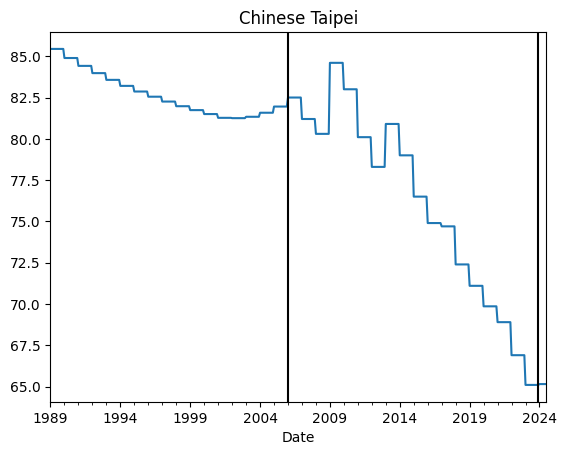

processing Thailand.csv


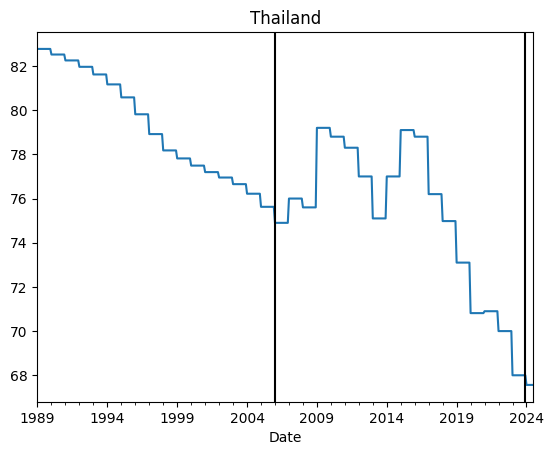

processing Indonesia.csv


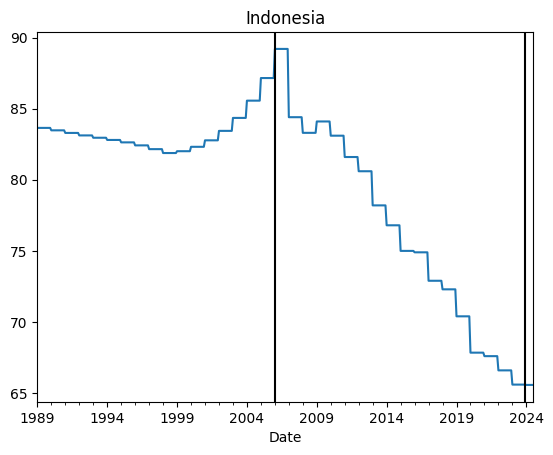

processing Turkey.csv


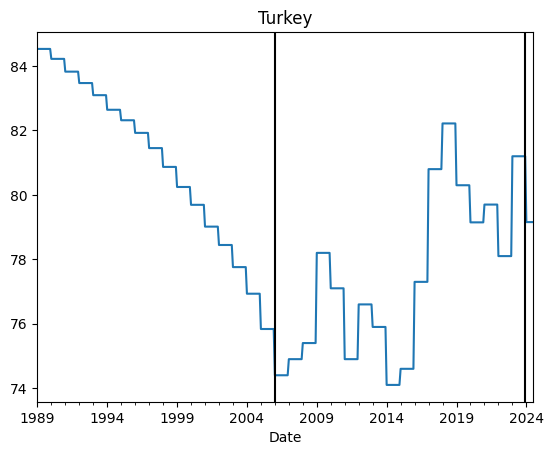

processing Macao, China.csv


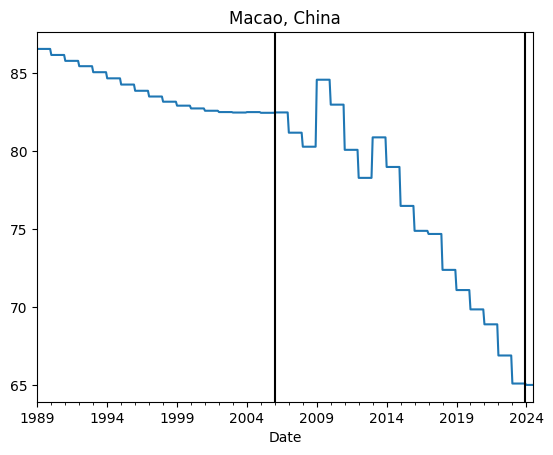

processing Australia.csv


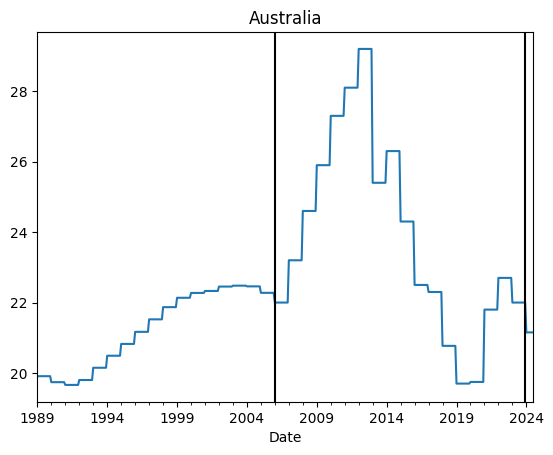

processing New Zealand.csv


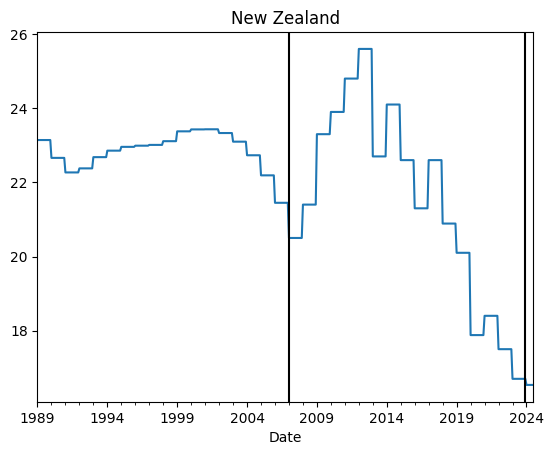

processing Czech.csv


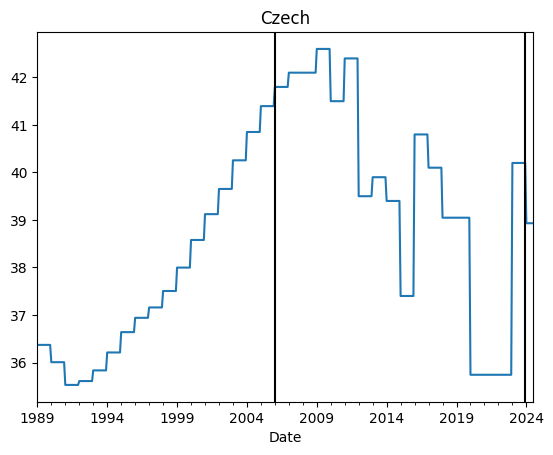

processing Hawaii.csv


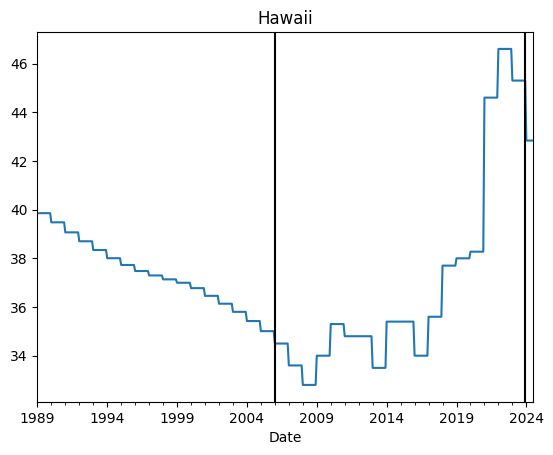

processing Mexico.csv


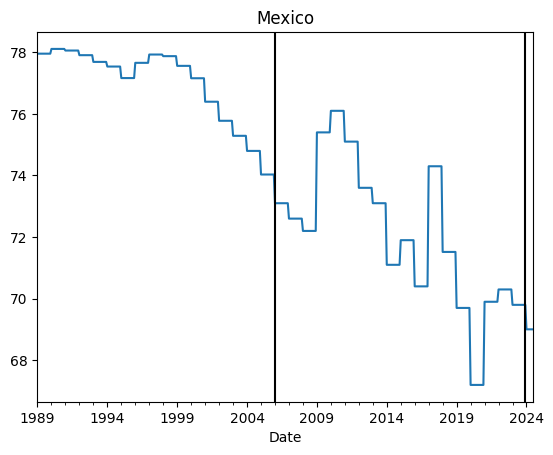

processing Hong Kong SAR.csv


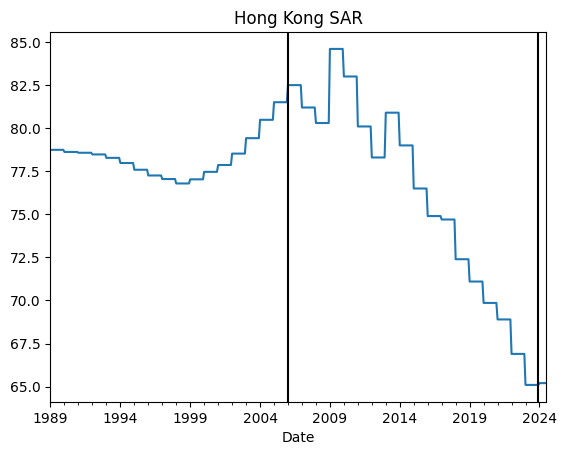

processing Canada.csv


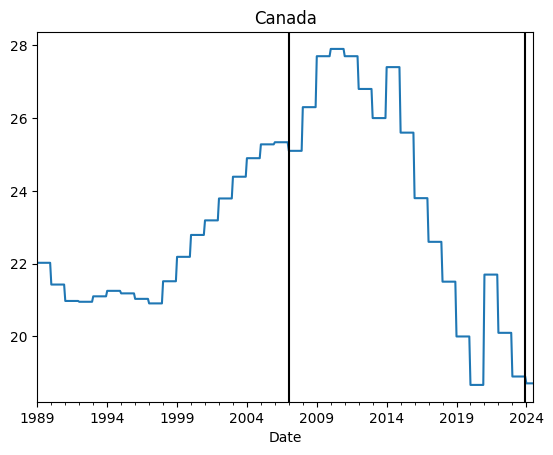

processing Austria.csv


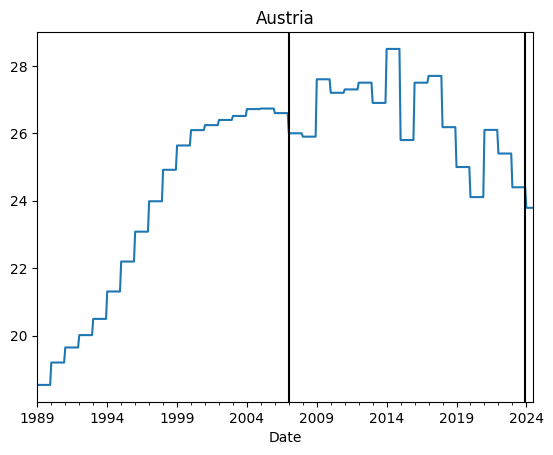

In [57]:
# combination regression predictions
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        country = f.split('.')[0]
        full_df = pd.read_csv(os.path.join(imputed_dir, f))
        full_df['Date'] = pd.to_datetime(full_df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        full_df = full_df.set_index('Date')
        start_date, end_date = full_df['FSI'].first_valid_index(), full_df['FSI'].last_valid_index()
        df = full_df.copy()
        df = df.resample('YS').first().reset_index(names='Date')
        # combination reg pred
        df.loc[:df['FSI'].first_valid_index() - 1, 'FSI'] = backward_comb_pred[country][::-1]
        df.loc[df['FSI'].last_valid_index() + 1:, 'FSI'] = forward_comb_pred[country]
        df = df.set_index('Date').resample('MS').ffill()
        
        full_df['FSI'] = full_df['FSI'].fillna(df['FSI']).ffill()
        full_df.reset_index(names='Date')
        full_df['FSI'].plot()
        plt.title(country)
        plt.axvline(start_date, color='black')
        plt.axvline(end_date, color='black')
        plt.show()
        # break
        # full_df.to_csv(os.path.join(imputed_dir, f))

processing Japan.csv


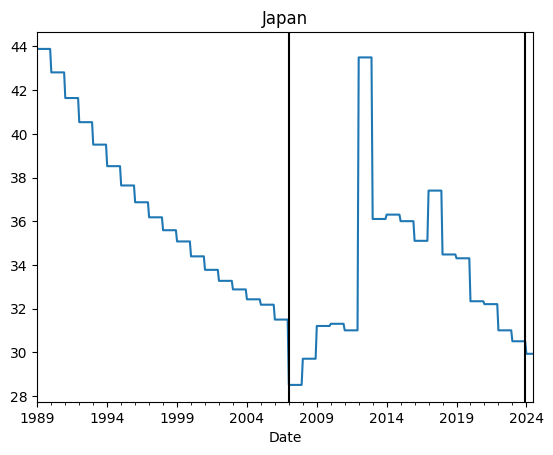

processing Korea (ROK).csv


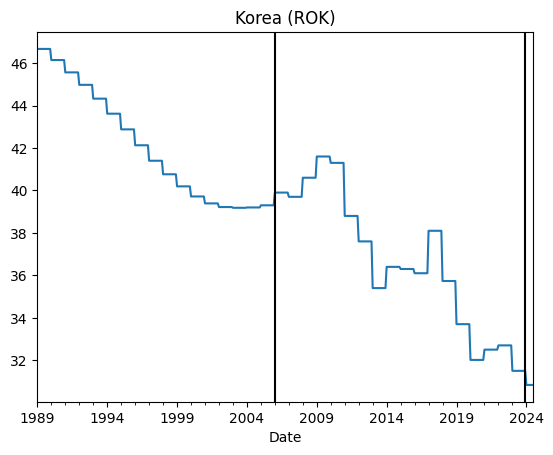

processing Chile.csv


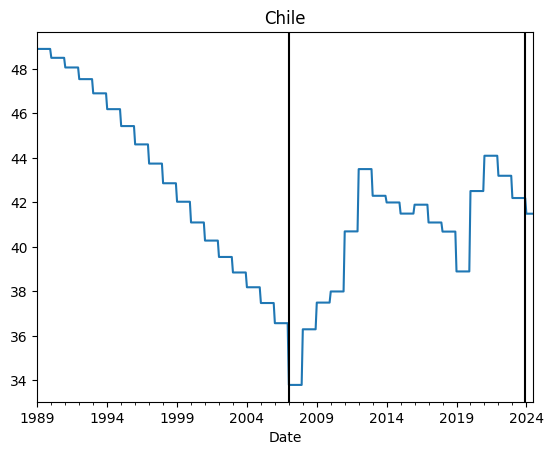

processing Maldives.csv


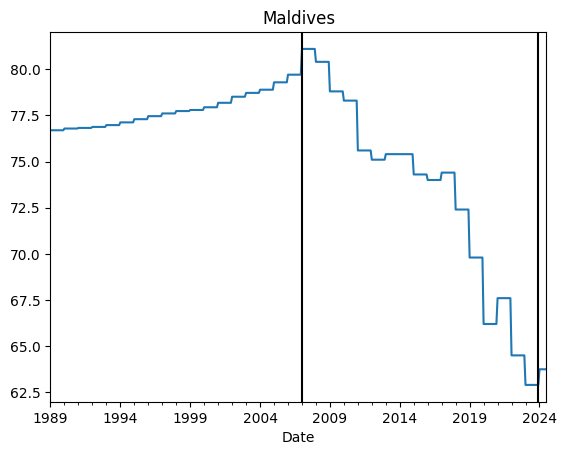

processing Cambodia.csv


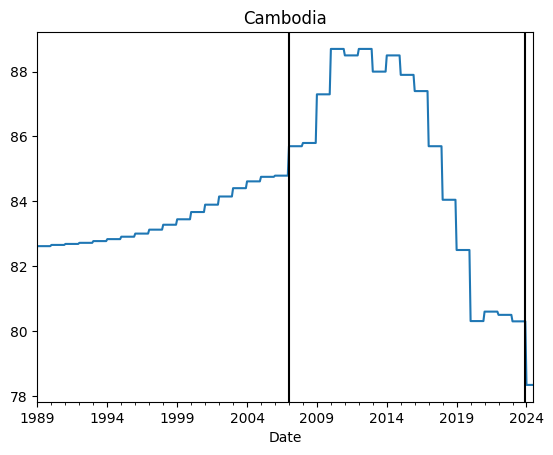

processing Singapore.csv


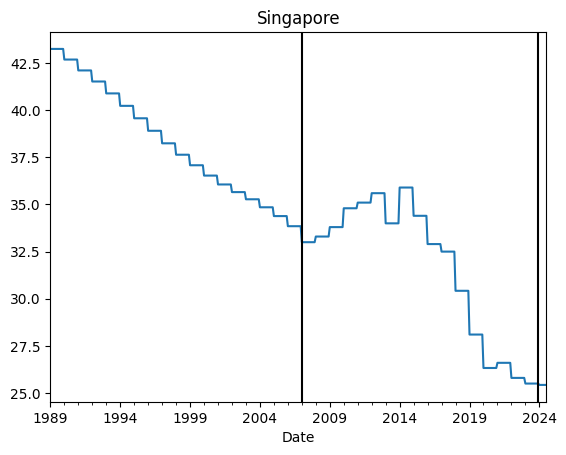

processing USA.csv


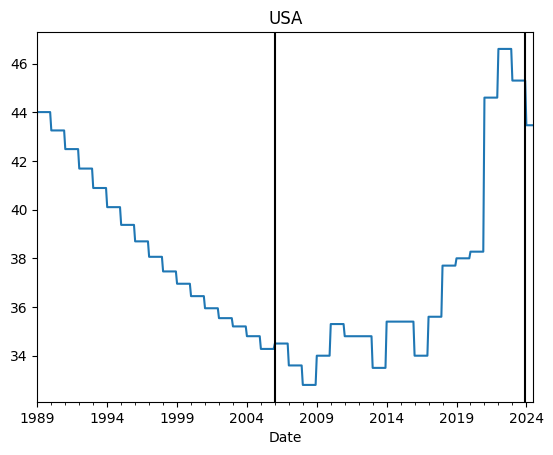

processing Chinese Taipei.csv


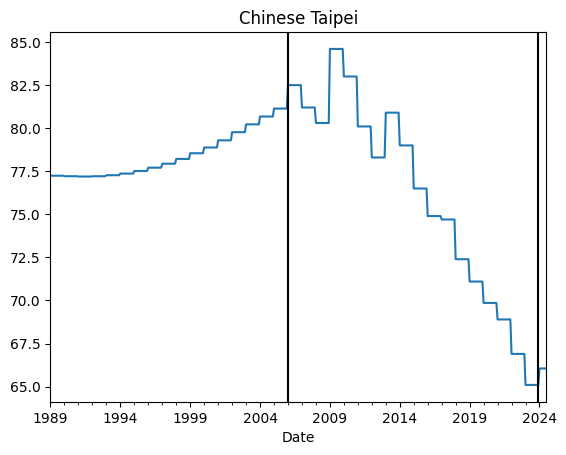

processing Thailand.csv


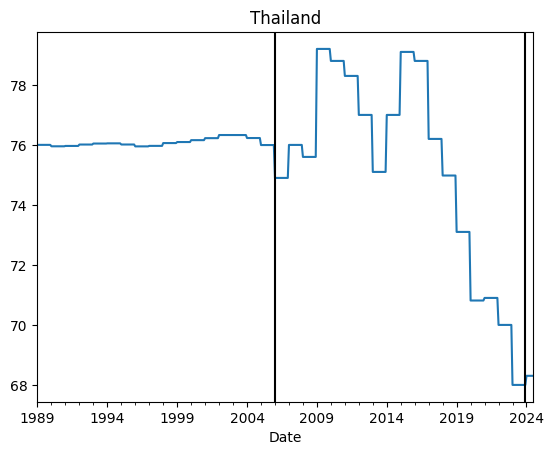

processing Indonesia.csv


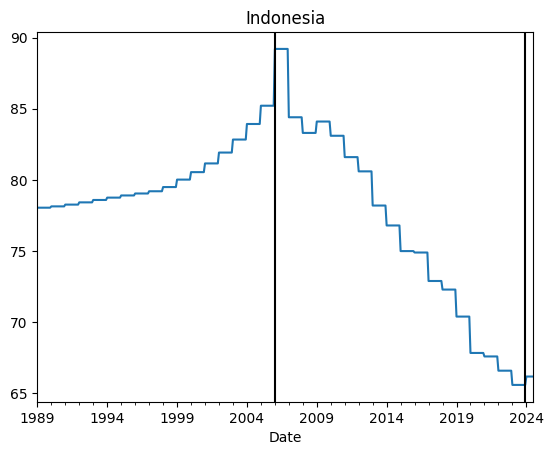

processing Turkey.csv


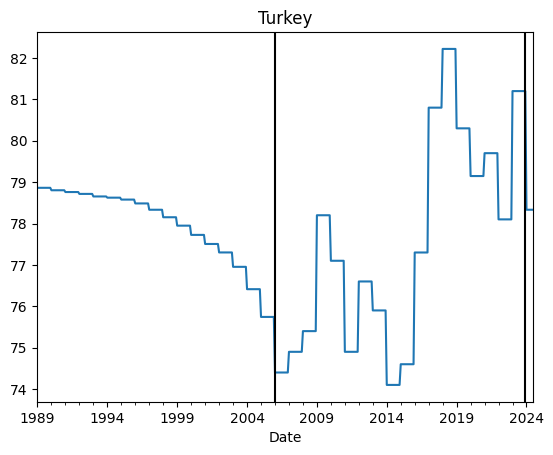

processing Macao, China.csv


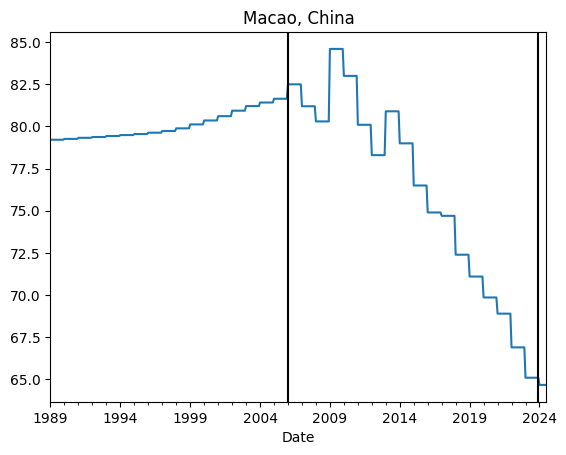

processing Australia.csv


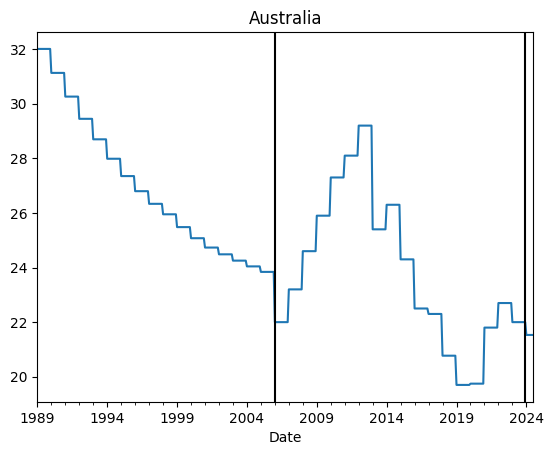

processing New Zealand.csv


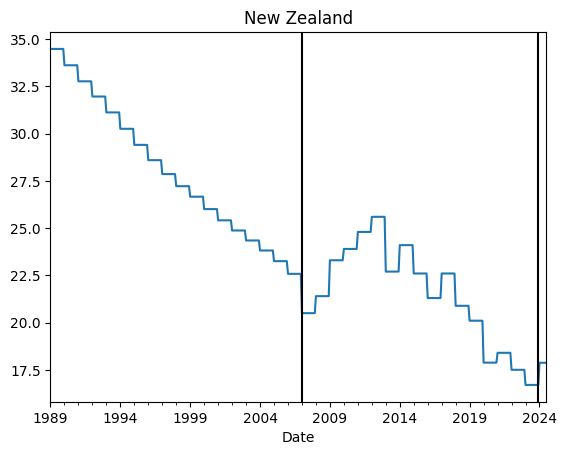

processing Czech.csv


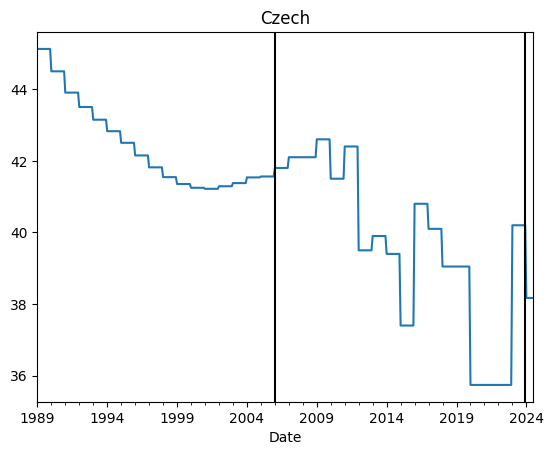

processing Hawaii.csv


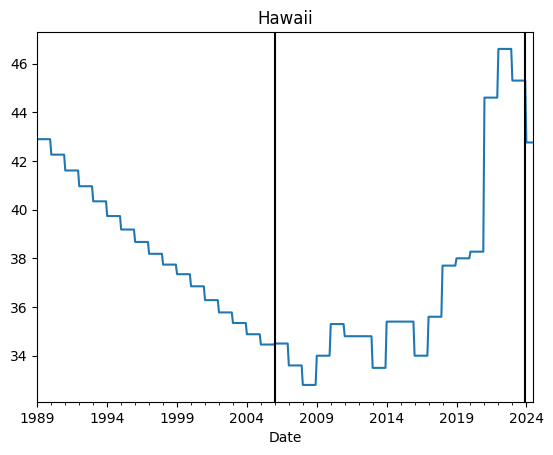

processing Mexico.csv


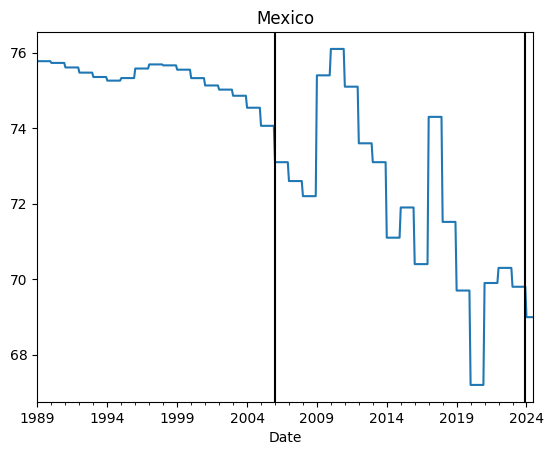

processing Hong Kong SAR.csv


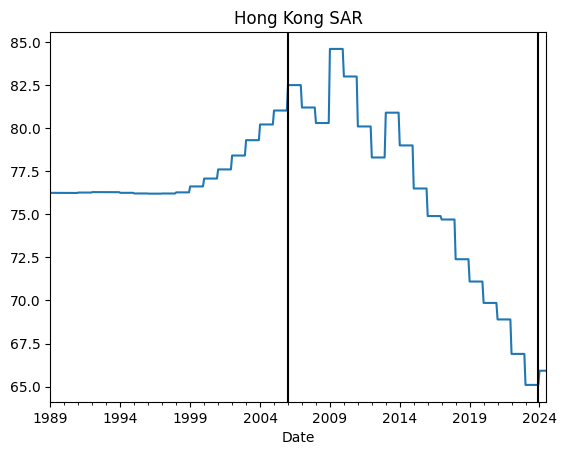

processing Canada.csv


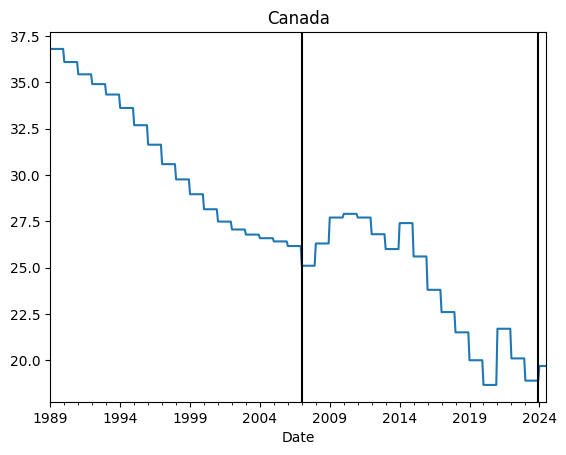

processing Austria.csv


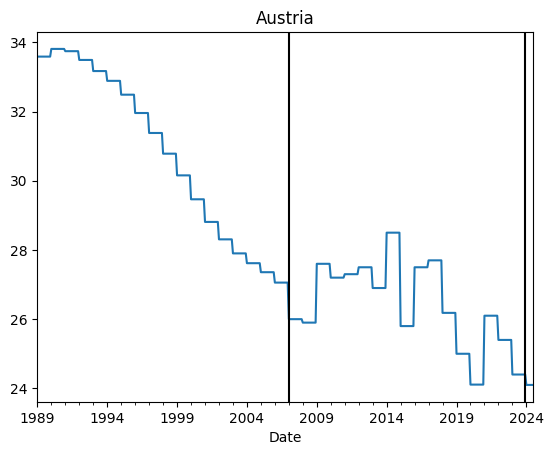

In [58]:
# ensembling regression + rnn predictions
for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        country = f.split('.')[0]
        full_df = pd.read_csv(os.path.join(imputed_dir, f))
        full_df['Date'] = pd.to_datetime(full_df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        full_df = full_df.set_index('Date')
        start_date, end_date = full_df['FSI'].first_valid_index(), full_df['FSI'].last_valid_index()
        df = full_df.copy()
        df = df.resample('YS').first().reset_index(names='Date')
        # ensembling
        weight = 0.7
        df.loc[:df['FSI'].first_valid_index() - 1, 'FSI'] = weight * np.array(backward_comb_pred[country][::-1]) + (1 - weight) * np.array(backcast_predictions[country][::-1])
        df.loc[df['FSI'].last_valid_index() + 1:, 'FSI'] = weight * np.array(forward_comb_pred[country]) + (1 - weight) * np.array(forecast_predictions[country])

        df = df.set_index('Date').resample('MS').ffill()
        
        full_df['FSI'] = full_df['FSI'].fillna(df['FSI']).ffill()
        full_df.reset_index(names='Date')
        full_df['FSI'].plot()
        plt.title(country)
        plt.axvline(start_date, color='black')
        plt.axvline(end_date, color='black')
        plt.show()
        # break
        full_df.to_csv(os.path.join(imputed_dir, f))

processing Japan.csv
(0, 1, 1) 3.4181463593563772
(0, 1, 1) 2.6985219093490973


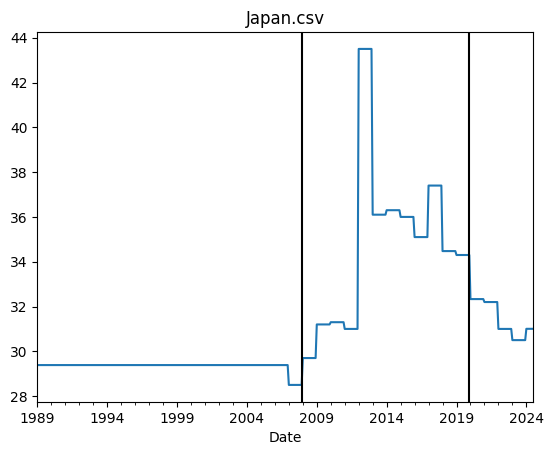

processing Korea (ROK).csv
(0, 1, 1) 2.1008618868178175
(1, 1, 1) 1.4749649687234982


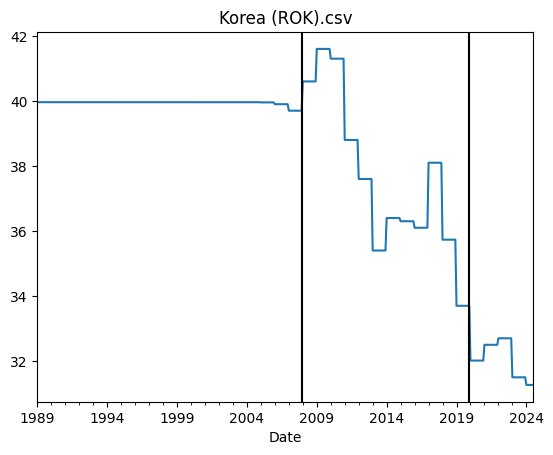

processing Chile.csv
(0, 1, 1) 0.9542391354574415
(0, 0, 1) 0.8083800508515406


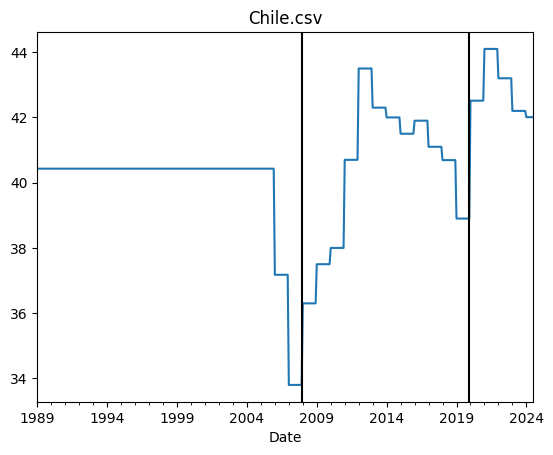

processing Maldives.csv
(0, 1, 1) 1.277874772253565
(1, 0, 2) 2.5882733332691683


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


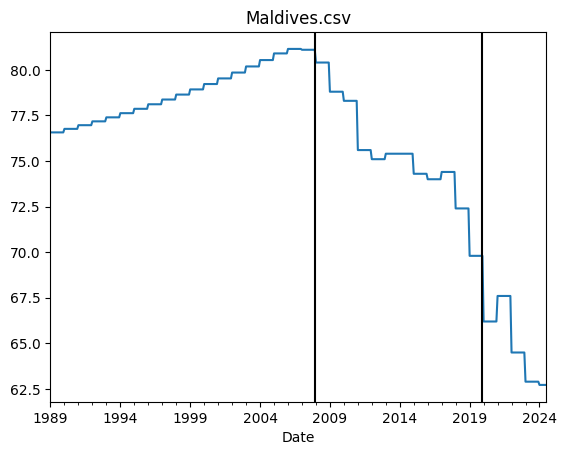

processing Cambodia.csv
(1, 1, 2) 1.0482132010186032
(1, 1, 2) 1.2764467671369666


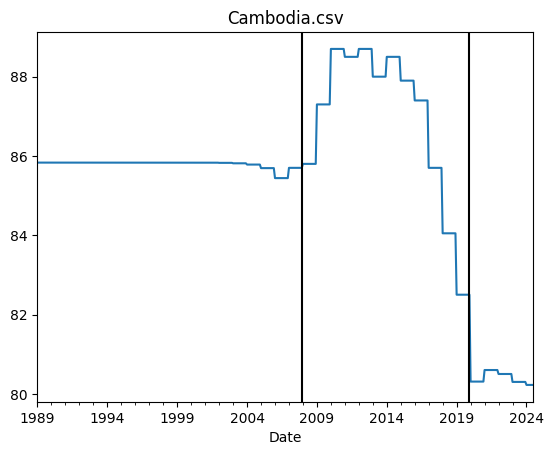

processing Singapore.csv
(1, 1, 2) 1.8438528210037433
(0, 1, 3) 2.0074533111230686


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


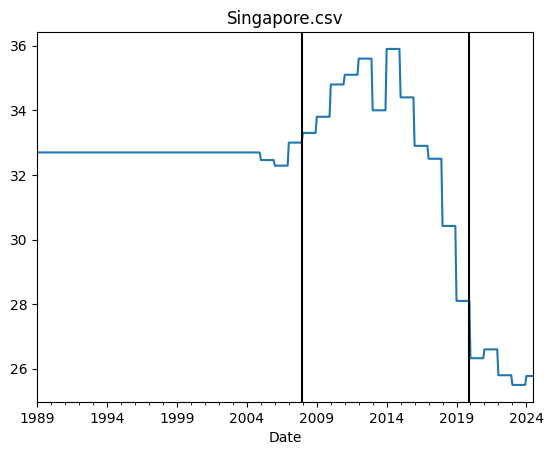

processing USA.csv
(1, 0, 1) 1.543266769587979
(1, 0, 1) 2.3357068037828683


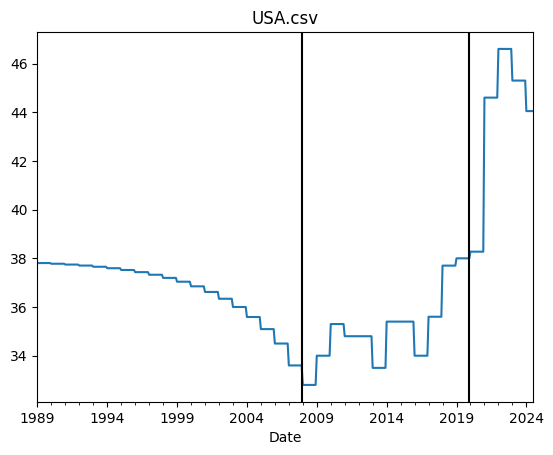

processing Chinese Taipei.csv
(1, 1, 3) 2.972269829612392


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 1) 3.4282238565716616


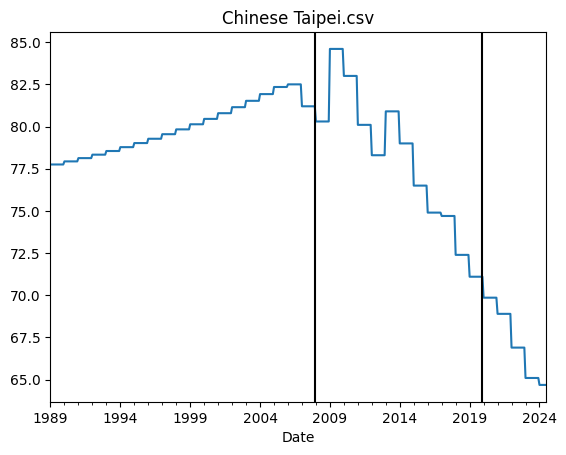

processing Thailand.csv
(0, 0, 3) 1.6263616407057306


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 1) 1.730696728111481


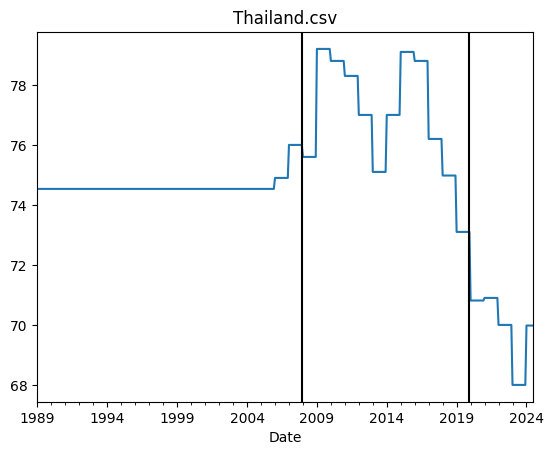

processing Indonesia.csv
(1, 1, 2) 1.178613022593426
(1, 1, 3) 0.6795975129226887


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


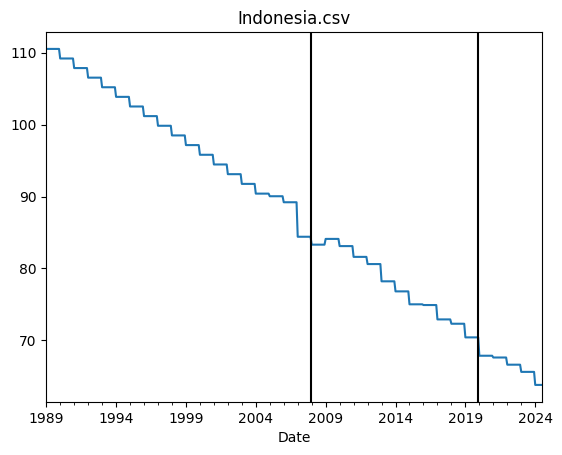

processing Turkey.csv
(1, 0, 1) 2.2507339638219057
(1, 0, 1) 2.5200536111246543


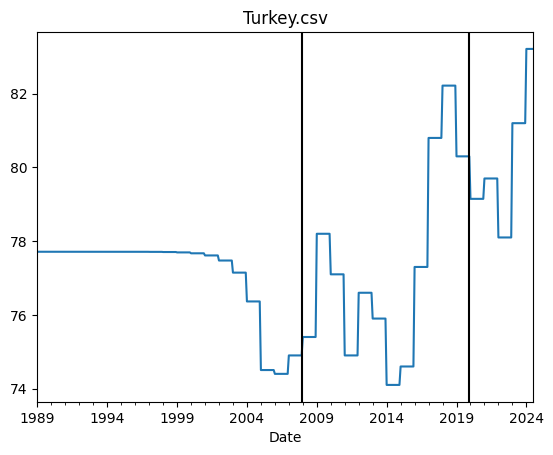

processing Macao, China.csv
(1, 1, 3) 2.972269829612392


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 1) 3.4282238565716616


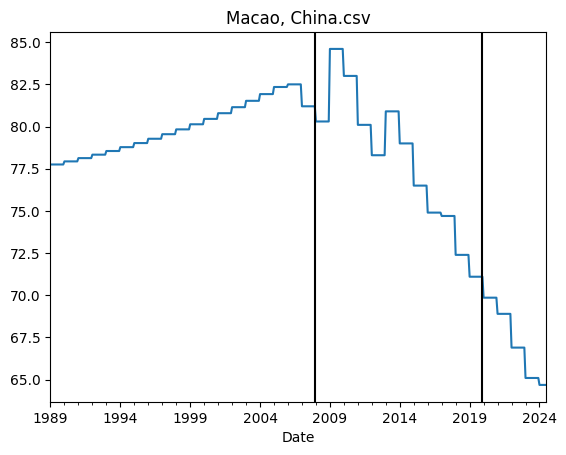

processing Australia.csv
(0, 1, 3) 1.599703439004182


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 2) 2.1509486009146386


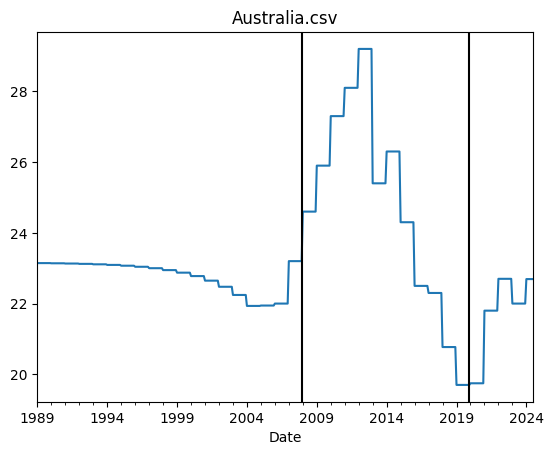

processing New Zealand.csv
(0, 0, 3) 1.5029822530155288


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 1, 1) 1.689082055637173


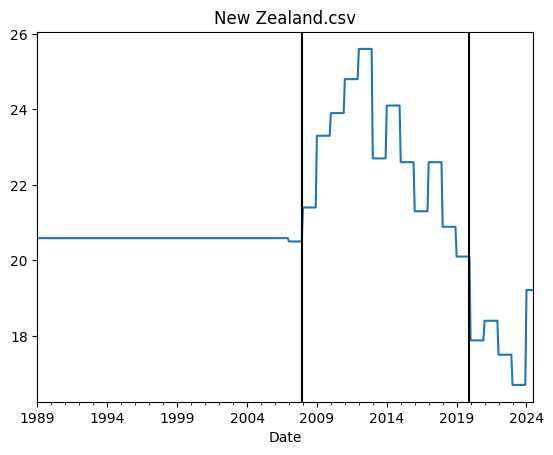

processing Czech.csv
(0, 0, 3) 1.9243678247497789


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 1) 1.8438599235289228


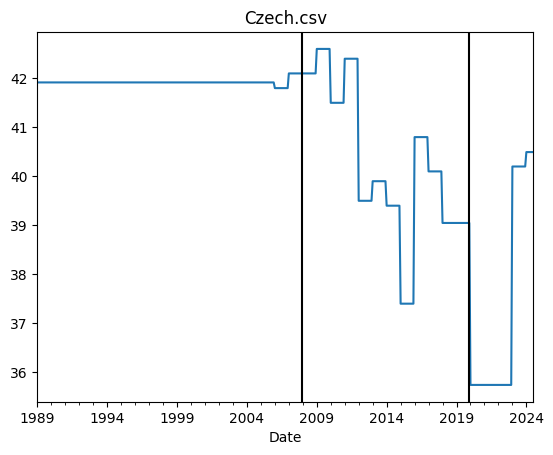

processing Hawaii.csv
(1, 0, 1) 1.543266769587979
(1, 0, 1) 2.3357068037828683


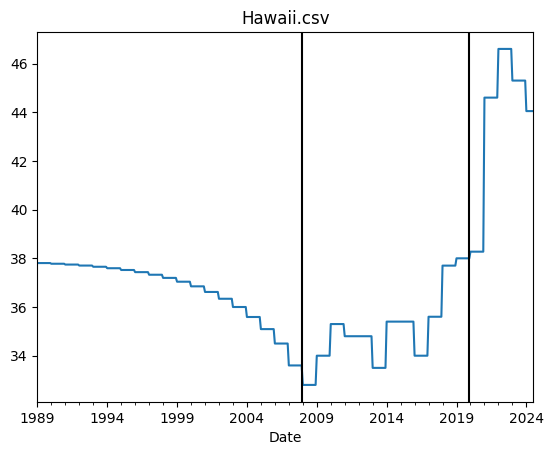

processing Mexico.csv
(1, 0, 1) 2.0528631063821754
(0, 1, 1) 2.127254960628521


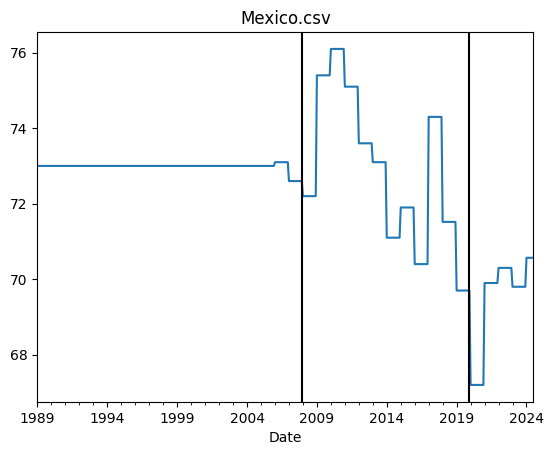

processing Hong Kong SAR.csv
(1, 1, 3) 2.972269829612392


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0, 1) 3.4282238565716616


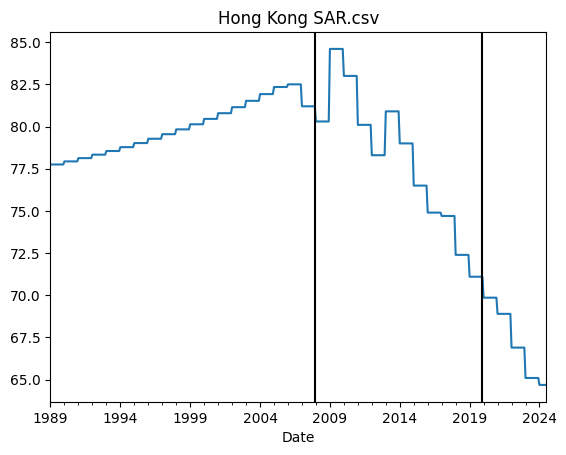

processing Canada.csv
(1, 1, 3) 1.67698227227171


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 3) 1.9088427794142302


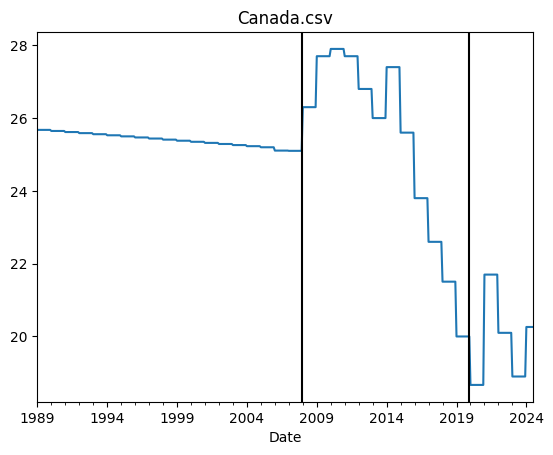

processing Austria.csv
(1, 0, 1) 0.9587995722115044
(0, 1, 2) 1.2511711313623146


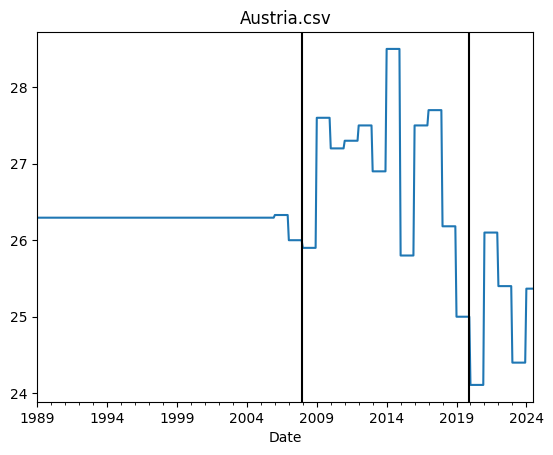

In [39]:
# repeat for all countries for arima, forward and backward

for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        full_df = pd.read_csv(os.path.join(imputed_dir, f))
        full_df['Date'] = pd.to_datetime(full_df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        full_df = full_df.set_index('Date')
        df = full_df.copy()
        df = df.resample('YS').first()
        
        # forward
        train_full = df['FSI']
        train_y = train_full.dropna()
        train_y, test_y = train_y.iloc[:-4], train_y.iloc[-4:]
        
        best_param, best_rmse = grid_search_arima(train_y)
        print(best_param, best_rmse)
        train_y = train_full.dropna()
        test_y = train_full[train_full.last_valid_index() + train_full.index.freq:]
        arima_model = sm.tsa.arima.ARIMA(train_y, order=best_param)
        result = arima_model.fit()
        pred = result.forecast(len(test_y))
        pred_df = pd.DataFrame({'FSI_Imputed': pred}, index=test_y.index).resample('MS').ffill()
        
        # backward
        train_full = df['FSI']
        train_y = train_full.dropna()
        train_y, test_y = train_y[::-1].iloc[:-4].values, train_y[::-1].iloc[-4:]
        
        best_param, best_rmse = grid_search_arima(train_y)
        print(best_param, best_rmse)
        train_y = train_full.dropna()[::-1]
        test_y = train_full[:train_full.first_valid_index() - train_full.index.freq][::-1]
        arima_model = sm.tsa.arima.ARIMA(train_y.values, order=best_param)
        result = arima_model.fit()
        backward_pred = result.forecast(len(test_y))
        backward_pred_df = pd.DataFrame({'FSI_Imputed': backward_pred}, index=test_y.index).sort_index().resample('MS').ffill()
        pred_df = pd.concat([backward_pred_df, pred_df])
        
        full_df['FSI'] = full_df['FSI'].fillna(full_df.merge(pred_df, how='left', left_index=True, right_index=True)['FSI_Imputed'].ffill())
        full_df.reset_index(names='Date')
        full_df['FSI'].plot()
        plt.title(f)
        plt.axvline(train_x.index.min(), color='black')
        plt.axvline(train_x.index.max(), color='black')
        plt.show()
        # full_df.to_csv(os.path.join(imputed_dir, f))
        # break

processing Japan.csv
('rf', 'nopreprocess', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 3.4483862551088564


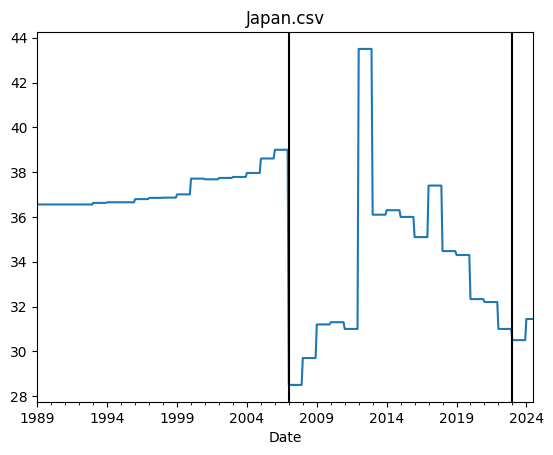

processing Korea (ROK).csv
('ridge', 'minmax', {'alpha_per_target': False, 'alphas': (0.1, 0.25, 0.5, 1.0, 5.0, 10.0), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'scoring': None, 'store_cv_values': False}) 1.6790677326102046


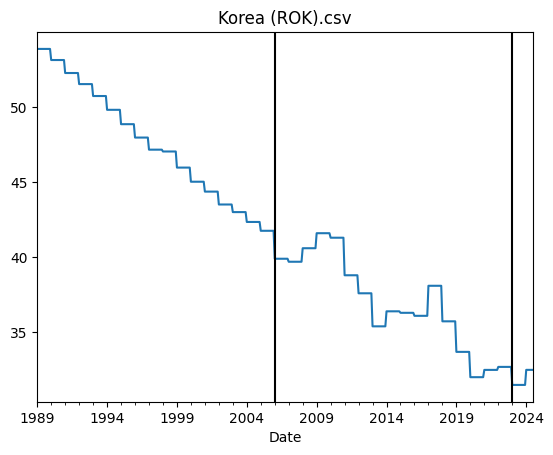

processing Chile.csv
('lr', 'standard', {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}) 0.8914196363043978


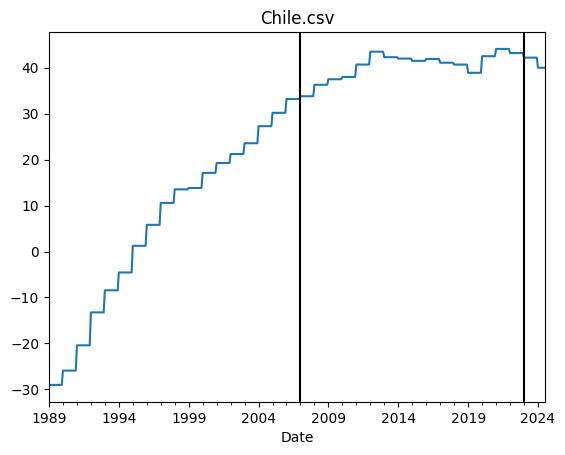

processing Maldives.csv
('ridge', 'minmax', {'alpha_per_target': False, 'alphas': (0.1, 0.25, 0.5, 1.0, 5.0, 10.0), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'scoring': None, 'store_cv_values': False}) 1.7683827098054015


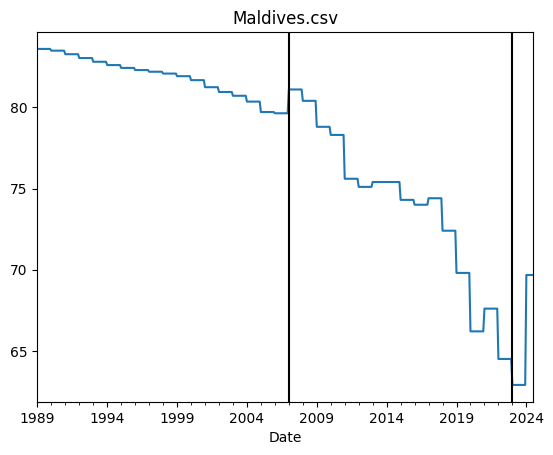

processing Cambodia.csv
('ridge', 'standard', {'alpha_per_target': False, 'alphas': (0.1, 0.25, 0.5, 1.0, 5.0, 10.0), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'scoring': None, 'store_cv_values': False}) 1.0319051773132297


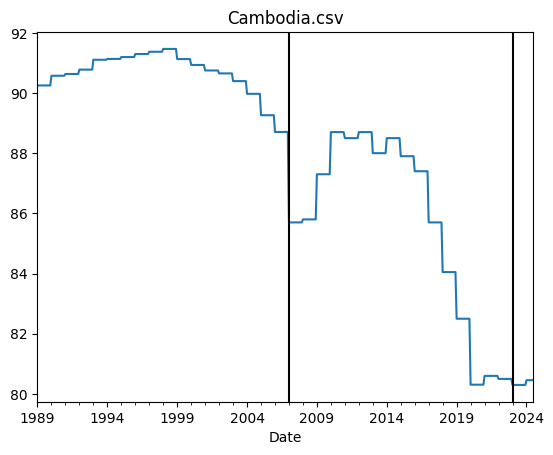

processing Singapore.csv
('rf', 'standard', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 3, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 1.6838820359311637


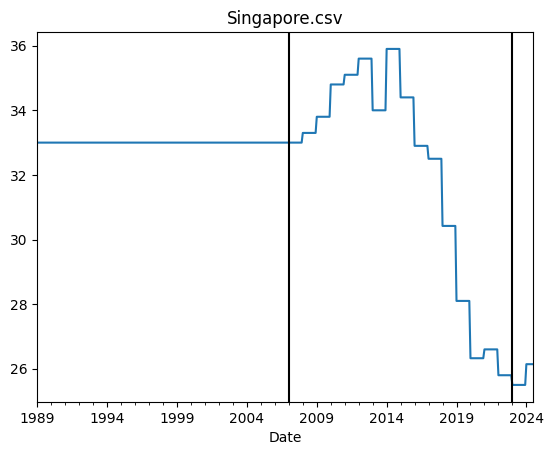

processing USA.csv
('rf', 'standard', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 3, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 1.3664273017286797


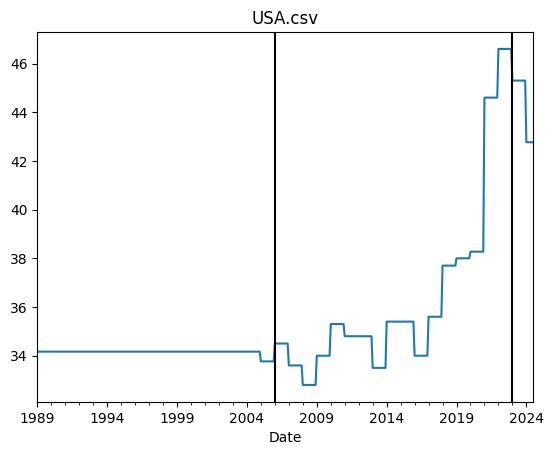

processing Chinese Taipei.csv
('lr', 'standard', {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}) 2.1577199757377383


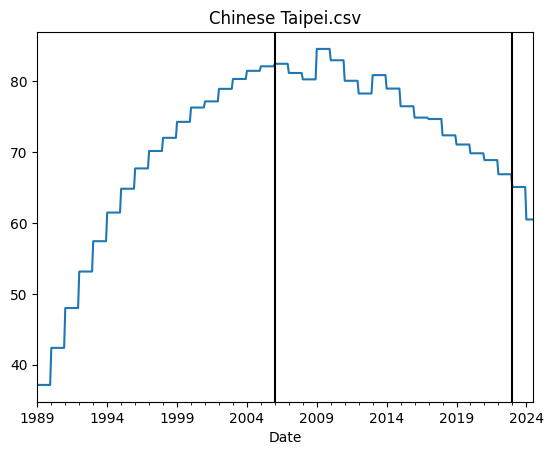

processing Thailand.csv
('elastic', 'minmax', {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0], 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 0}) 1.3600742038786913


/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016708282554787957, tolerance: 0.016555872464051564
  model = cd_fast.enet_coordinate_descent_gram(
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024968842935834346, tolerance: 0.016555872464051564
  model = cd_fast.enet_coordinate_descent_gram(
/scratch/zt00296/.conda/envs/tourism/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03771511201360056, tolerance: 0.016555872464051564
  model = cd_fast.enet_coordinate_descent_gram(
/scratch

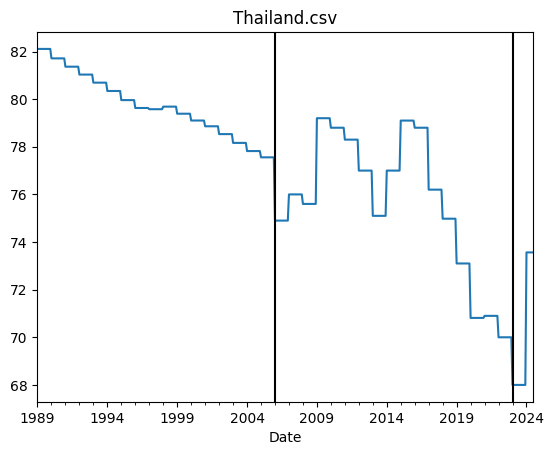

processing Indonesia.csv
('ridge', 'minmax', {'alpha_per_target': False, 'alphas': (0.1, 0.25, 0.5, 1.0, 5.0, 10.0), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'scoring': None, 'store_cv_values': False}) 0.8581752680556193


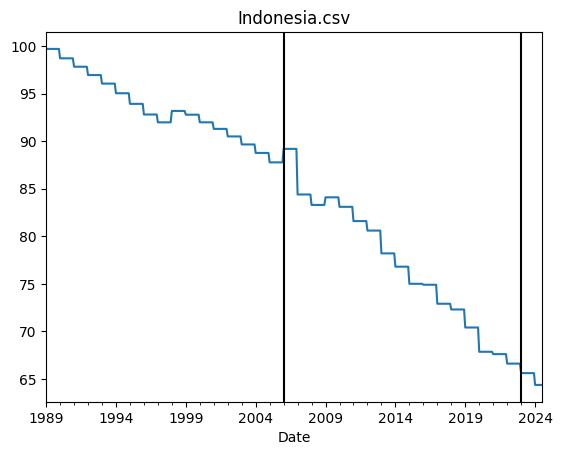

processing Turkey.csv
('rf', 'standard', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 5, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 1.640597758629729


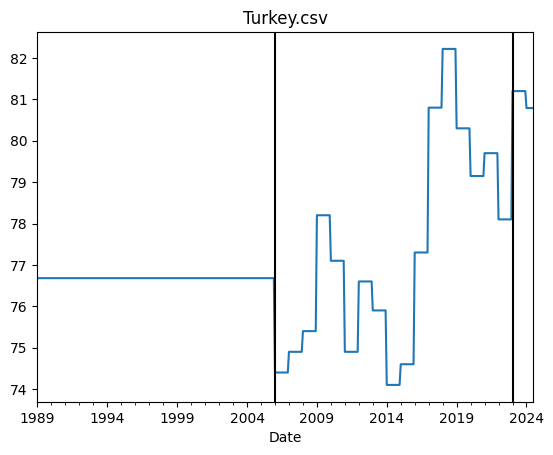

processing Macao, China.csv
('rf', 'standard', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 1.8021042593272143


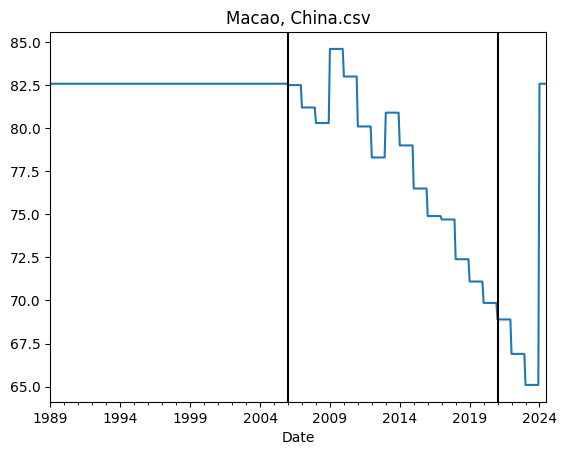

processing Australia.csv
('lr', 'standard', {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}) 1.4422131350487597


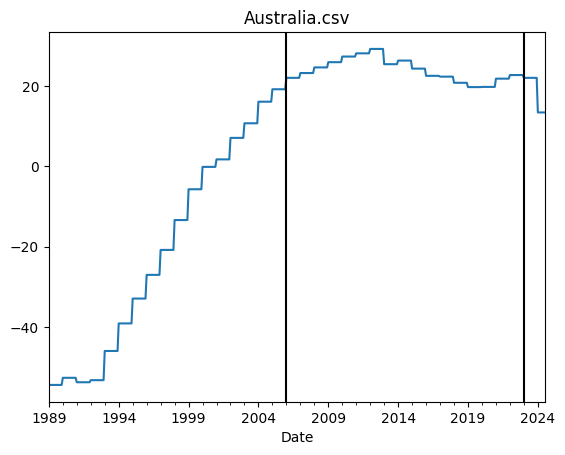

processing New Zealand.csv
('lr', 'standard', {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}) 1.6461144975516013


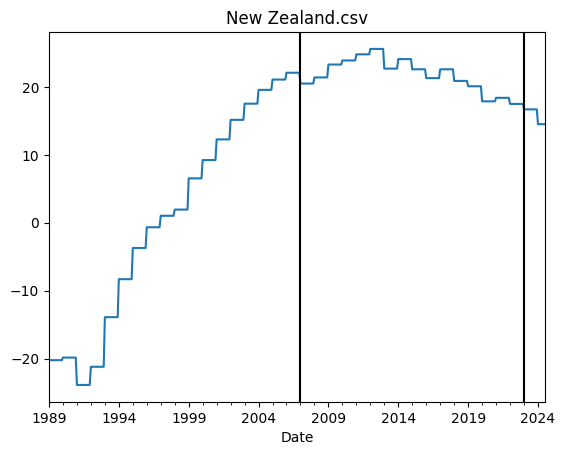

processing Czech.csv
('rf', 'nopreprocess', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 1.2427109943716705


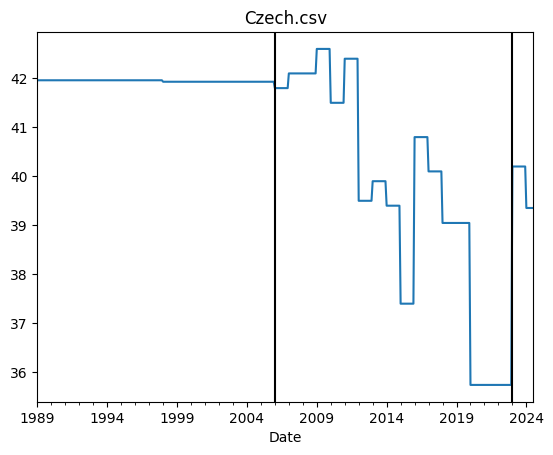

processing Hawaii.csv
('rf', 'minmax', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 3, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 1.262773472330126


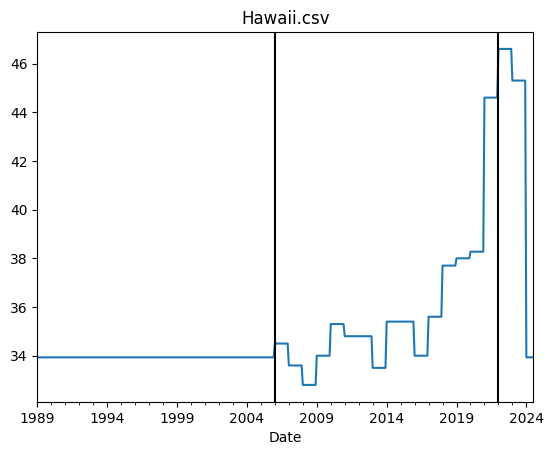

processing Mexico.csv
('rf', 'nopreprocess', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 5, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 1.9182460629529907


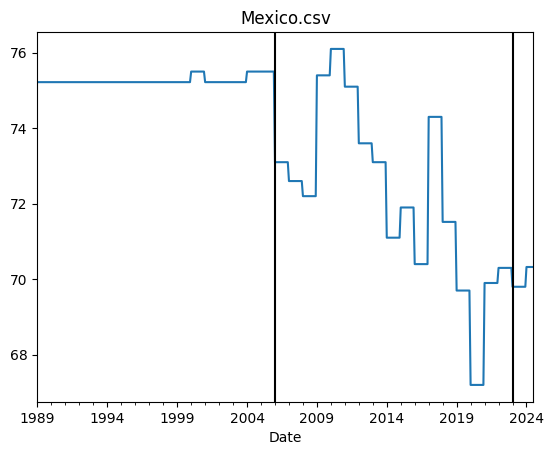

processing Hong Kong SAR.csv
('rf', 'minmax', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 3, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 2.4119567595354052


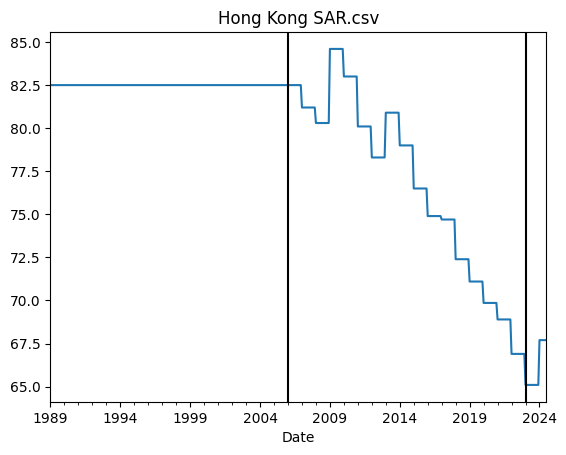

processing Canada.csv
('xgb', 'nopreprocess', {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 50, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}) 1.6414674692913578


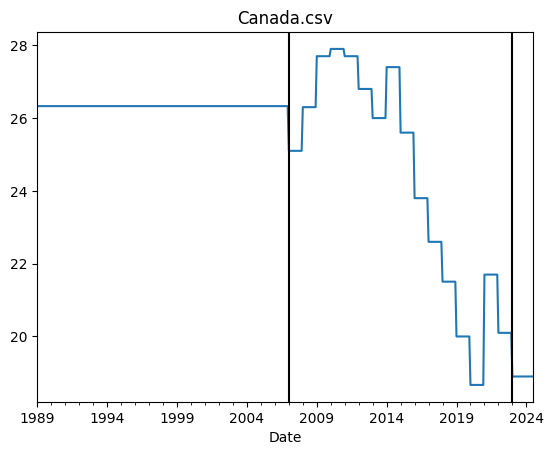

processing Austria.csv
('rf', 'standard', {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 5, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}) 0.9949062318714459


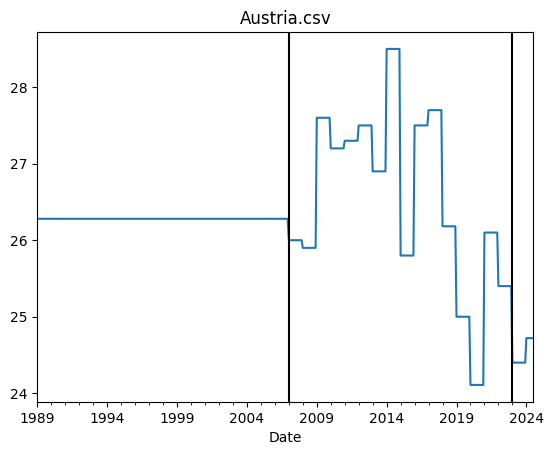

In [40]:
# repeat for all countries for regression
candidates = ['GDPPerCap', 'GDP', 'Population']
agg = {'FSI': lambda x: x.iloc[0], 'GDPPerCap': lambda x: x.iloc[0], 'GDP': lambda x: x.iloc[0], 'Population': lambda x: x.iloc[0],}
       # 'CovidCases': np.sum, 'CovidDeaths': np.sum}

for f in os.listdir(imputed_dir):
    if f.endswith('.csv'):
        print('processing', f)
        full_df = pd.read_csv(os.path.join(imputed_dir, f))
        full_df['Date'] = pd.to_datetime(full_df['Date'])
        # df = df[df['Date'] < '2020-01-01']
        full_df = full_df.set_index('Date')
        df = full_df.copy()
        df = df.resample('YS').agg(agg)
        # df['CovidDeaths'].iloc[-1] = df['CovidDeaths'].iloc[-2]//2  # assume 2024 covid cases would be half this year
        # df['CovidCases'].iloc[-1] = df['CovidCases'].iloc[-2]//2
        
        train_df = df[['FSI'] + candidates].dropna()
        train_x, train_y = train_df[candidates], train_df['FSI']
        train_x, test_x, train_y, test_y = train_x.iloc[:-4], train_x.iloc[-4:], train_y.iloc[:-4], train_y.iloc[-4:]
        # sample_weight = get_sample_weight(0.5, 1.0, len(train_x))

        best_param, best_rmse = grid_search_reg(train_x, train_y, #sample_weight=sample_weight,
                                                         additional_params={'rf': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)],
                                                                            'mlp': [{'hidden_layer_sizes': n} for n in (1, 2, 3, 5, 10)],
                                                                            'xgb': [{'n_estimators': n} for n in (3, 5, 10, 50, 100)]})
        print(best_param, best_rmse)
        model = get_model(best_param[0])
        model = model.set_params(**best_param[2])
        scaler = get_scaler(best_param[1])
        train_x, train_y = train_df[candidates], train_df['FSI']
        test_x = df[df['FSI'].isna()][candidates].dropna()
        train_x_ = scaler.fit_transform(train_x)
        test_x_ = scaler.transform(test_x)
        model.fit(train_x_, train_y,)# sample_weight=sample_weight)
        pred = model.predict(test_x_)
        pred_df = pd.DataFrame({'FSI_Imputed': pred}, index=test_x.index).resample('MS').ffill()
        full_df['FSI'] = full_df['FSI'].fillna(full_df.merge(pred_df, how='left', left_index=True, right_index=True)['FSI_Imputed'].ffill())
        full_df.reset_index(names='Date')
        full_df['FSI'].plot()
        plt.title(f)
        plt.axvline(train_x.index.min(), color='black')
        plt.axvline(train_x.index.max(), color='black')
        plt.show()
        # full_df.to_csv(os.path.join(imputed_dir, f))
        # break

In [59]:
# fix hawaii since we copied its value from USA?
hawaii_df = pd.read_csv(os.path.join(imputed_dir, 'Hawaii.csv'))
usa_df = pd.read_csv(os.path.join(imputed_dir, 'USA.csv'))
assert len(hawaii_df) == len(usa_df)
hawaii_df['FSI'] = usa_df['FSI']
hawaii_df.to_csv(os.path.join(imputed_dir, 'Hawaii.csv'), index=False)